In [3]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import uproot
import mplhep as hep
import boost_histogram as bh
from uncertainties import unumpy as unp
from plotting_cfg import plotting_config

In [4]:
files_2022 = sorted(glob.glob("output_2022/*.root"))
files_2023 = sorted(glob.glob("output_2023/*.root"))
files_2024 = sorted(glob.glob("output_2024/*.root"))

In [5]:
def legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [
        (h, l)
        for i, (h, l) in enumerate(zip(handles, labels))
        if l not in labels[:i]
    ]
    ax.legend(*zip(*unique), frameon=False)

In [4]:
def plot_track_yields(files_2022, files_2023, files_2024, bad_runs=None, min_lumi=10):

    fig, ax = plt.subplots(figsize=(48, 6))
    run_numbers = []
    lumis = []
    def plot_yield_for_run(fpath, index):
        data = uproot.open(fpath)
        metadata = data['dq'].arrays()
        lumi = metadata['lumi'][0]*1000
        run = np.ravel(metadata['run_number'])[0]

        if lumi < min_lumi: return False # lumi < min_lumi /pb
        if run in bad_runs: return False
        run_numbers.append(run)

        h_good_trk_yield = data['GoodTrkYield'].to_boost()
        h_pos_good_trk_yield = data['GoodPosTrkYield'].to_boost()
        h_neg_good_trk_yield = data['GoodNegTrkYield'].to_boost()

        lumi = unp.uarray(lumi, 0.022 * lumi)
        good_trk_yields = unp.uarray(h_good_trk_yield.values(), np.sqrt(h_good_trk_yield.values()))/lumi
        good_pos_trk_yields = unp.uarray(h_pos_good_trk_yield.values(), np.sqrt(h_pos_good_trk_yield.values()))/lumi
        good_neg_trk_yields = unp.uarray(h_neg_good_trk_yield.values(), np.sqrt(h_neg_good_trk_yield.values()))/lumi

        ax.errorbar([index], unp.nominal_values(good_trk_yields), yerr=unp.std_devs(good_trk_yields), xerr=0.5, linestyle="", linewidth=1, color='blue', label="All Good Tracks")
        ax.errorbar([index], unp.nominal_values(good_pos_trk_yields), yerr=unp.std_devs(good_trk_yields), xerr=0.5, linestyle="", linewidth=1, color='orange', label="Pos. Good Tracks")
        ax.errorbar([index], unp.nominal_values(good_neg_trk_yields), yerr=unp.std_devs(good_trk_yields), xerr=0.5, linestyle="", linewidth=1, color='red', label="Neg. Good Tracks")
        return True

    index = 0
    indices = []
    for i, fpath in enumerate(files_2022):
        if plot_yield_for_run(fpath, index): 
            indices.append(index)    
            index += 1
    index_end_2022 = index
    ax.axvline(index_end_2022 - 0.5, color="k", linestyle="--",)

    for i, fpath in enumerate(files_2023):
        if plot_yield_for_run(fpath, index): 
            indices.append(index)
            index += 1
    index_end_2023 = index
    ax.axvline(index_end_2023 - 0.5, color="k", linestyle="--",)

    for i, fpath in enumerate(files_2024):
        if plot_yield_for_run(fpath, index):
            indices.append(index)
            index += 1
    index_end_2024 = index
    ax.axvline(index_end_2024 - 0.5, color="k", linestyle="--",)

    ax.set_ylim(0, 1.1 * ax.get_ylim()[1])
    ax.text(index_end_2022 / 2, ax.get_ylim()[1] * 0.98, "2022", fontsize=18, ha="center", va="top",)
    ax.text(index_end_2022/2 + index_end_2023 / 2, ax.get_ylim()[1] * 0.98, "2023", fontsize=18, ha="center", va="top",)
    ax.text(index_end_2023/2 + index_end_2024 / 2, ax.get_ylim()[1] * 0.98, "2024", fontsize=18, ha="center", va="top",)

    ax.set_xlim(indices[0] - 0.5, indices[-1] + 0.5)
    ax.set_xticks(indices)
    ax.set_xticklabels(run_numbers, rotation="vertical", fontsize=8)
    legend(ax)
    plt.savefig("TrackYield.png", dpi=300)

In [6]:
bad_runs = [15075, 15146, 15181, 15257, 15259, 15260, 15694, 16669]

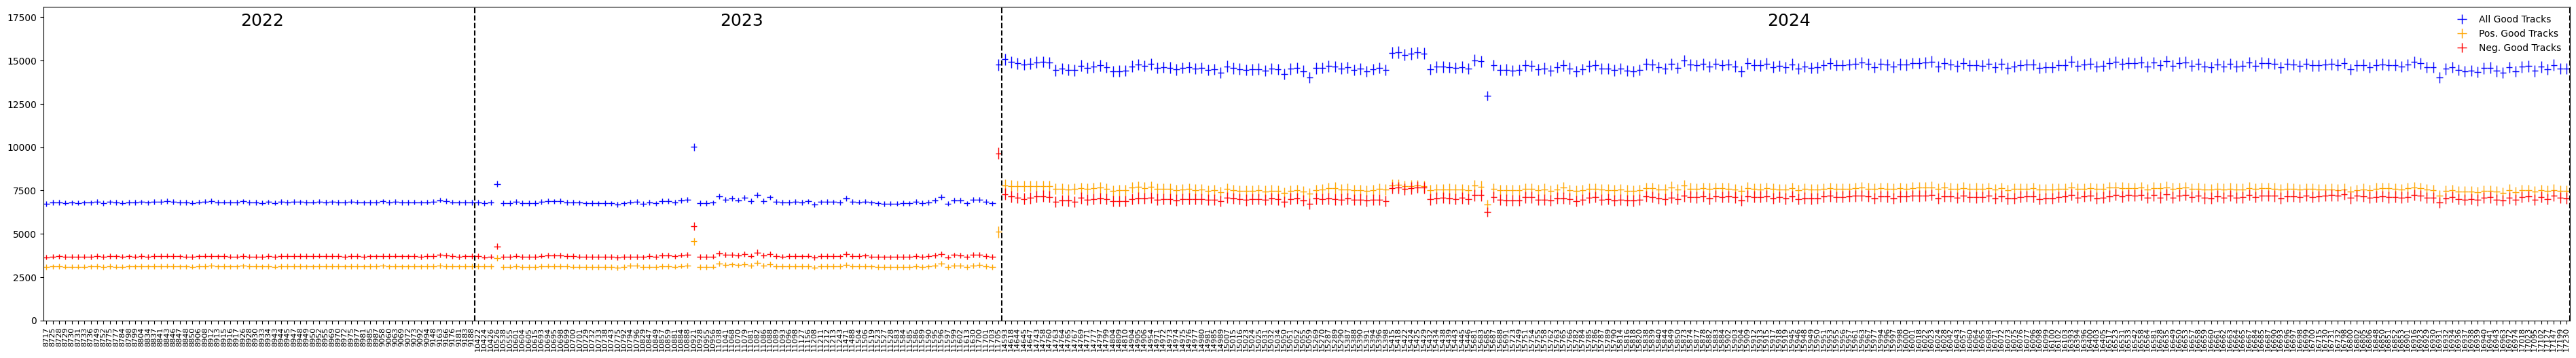

In [6]:
plot_track_yields(files_2022, files_2023, files_2024, bad_runs=bad_runs)

In [ ]:
def plot_dq_hists(files_2022, files_2023, files_2024, plotting_config, bad_runs=None):
    
    def plot_variable_for_run(ax, fpath, config, colour, year):
        data = uproot.open(fpath)
        metadata = data['dq'].arrays()
        lumi = metadata['lumi'][0]*1000
        run = np.ravel(metadata['run_number'])[0]

        if lumi < 10: return False # lumi < 10 /pb
        if run in bad_runs: return False

        if run == 10526: colour='purple'
        if run == 10921: colour='green'
        if run == 11705: colour='cyan'
        
        if run not in [10526, 10921, 11705]: return False

        hist = data[config['label']]
        hep.histplot(
            hist,
            histtype="errorbar",
            xerr=True,
            marker="",
            color=colour,
            label=year,
            density=True,
            ax=ax,
        )
        return True

    for cfg in plotting_config.values():
        fig, ax = plt.subplots(figsize=(8, 6))
        for fpath in files_2022: plot_variable_for_run(ax, fpath, cfg, 'red', '2022')
        for fpath in files_2023: plot_variable_for_run(ax, fpath, cfg, 'blue', '2023')
        for fpath in files_2024: plot_variable_for_run(ax, fpath, cfg, 'orange', '2024')
        ax.set_xlabel(cfg["xlabel"], fontsize=18)
        ax.set_title(cfg["title"], fontsize=18)
        legend(ax)
        plt.savefig(f"{cfg['name']}.png", dpi=300)
        plt.show()


: 

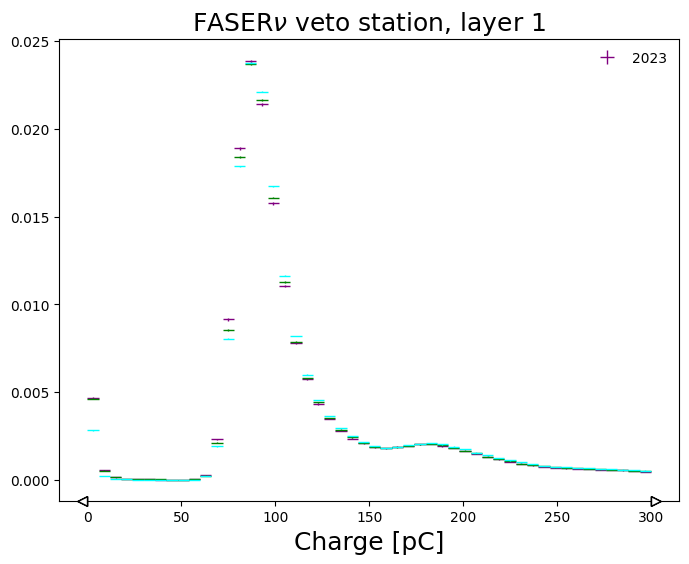

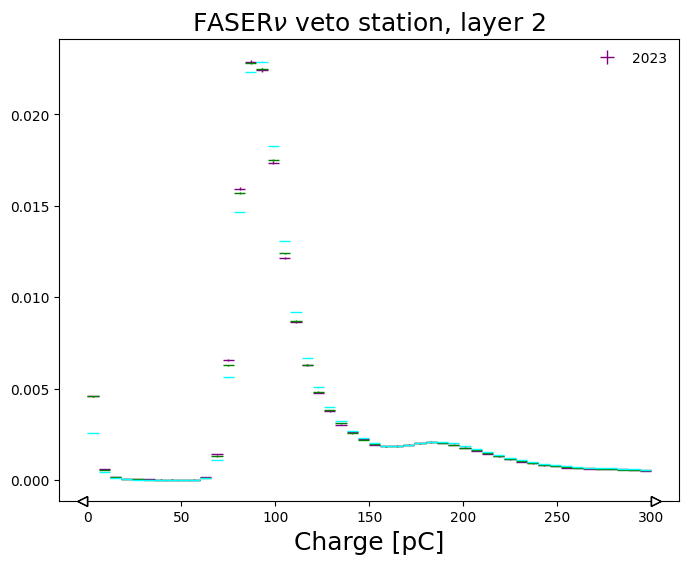

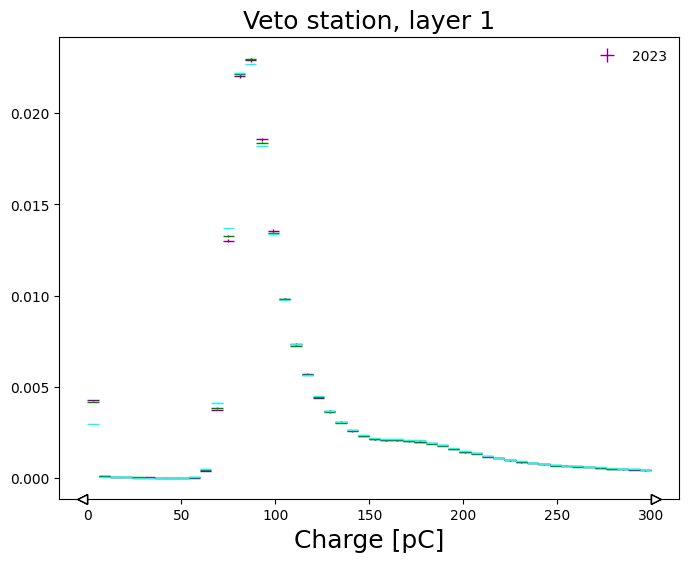

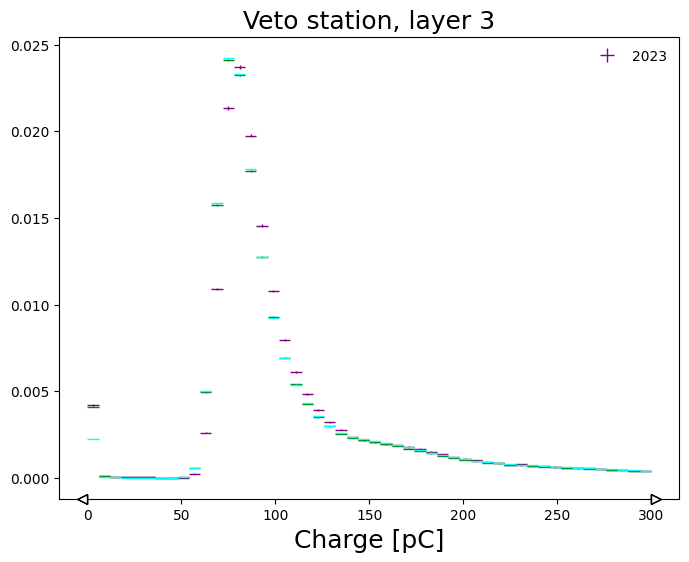

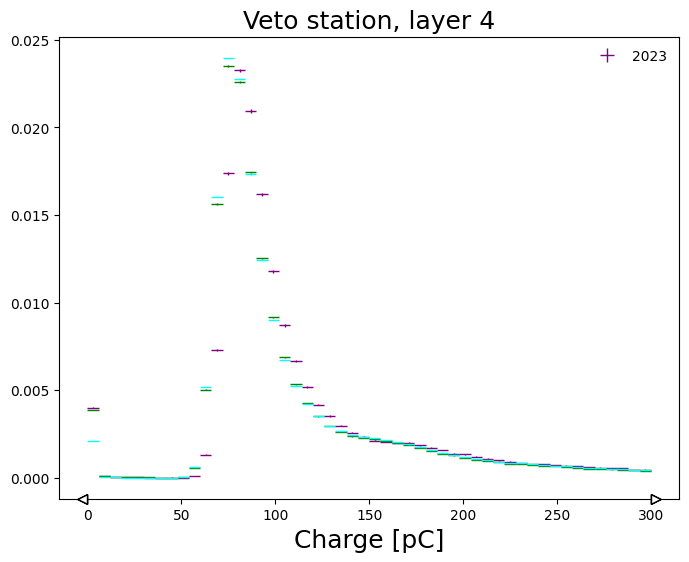

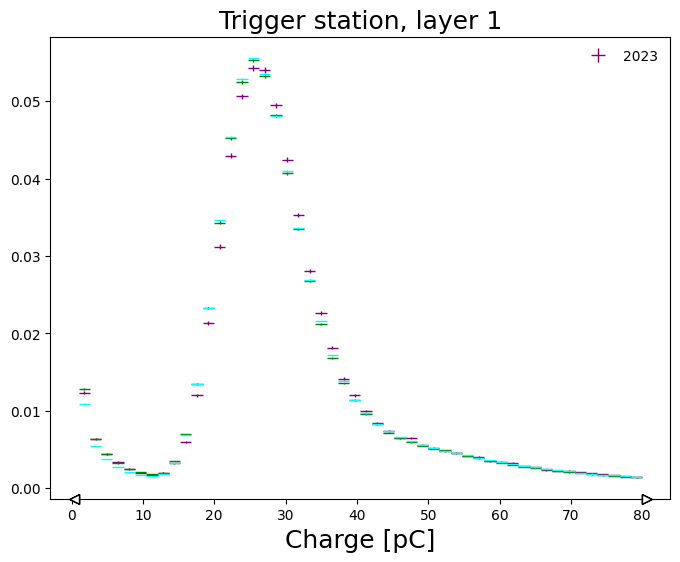

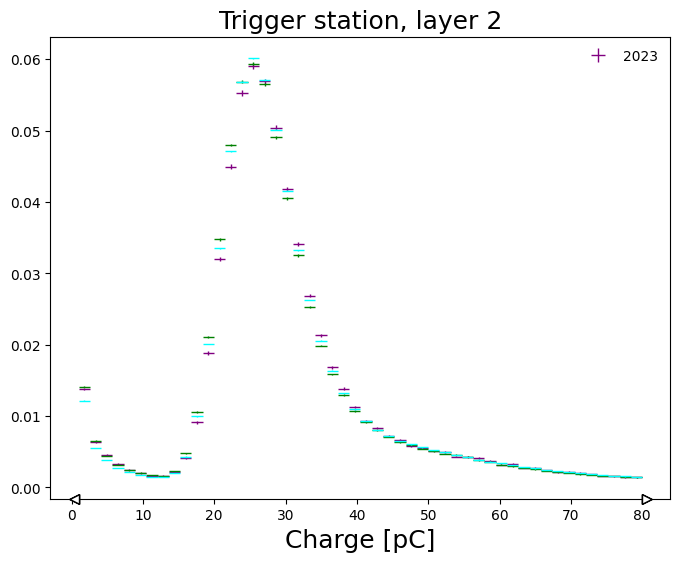

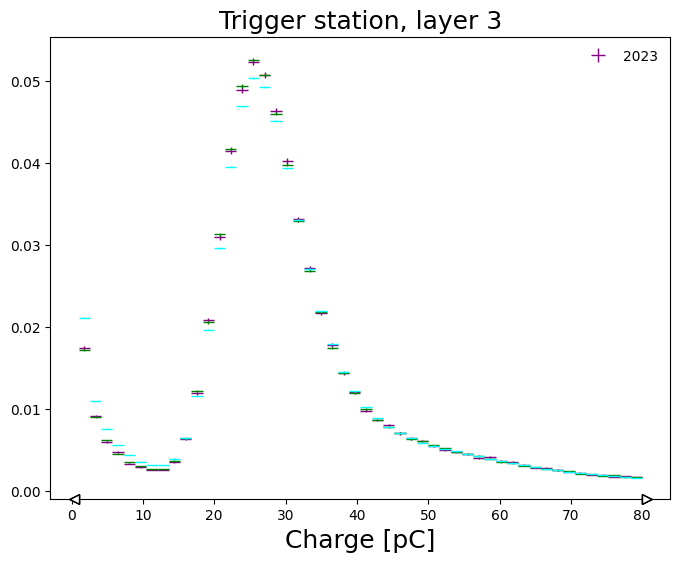

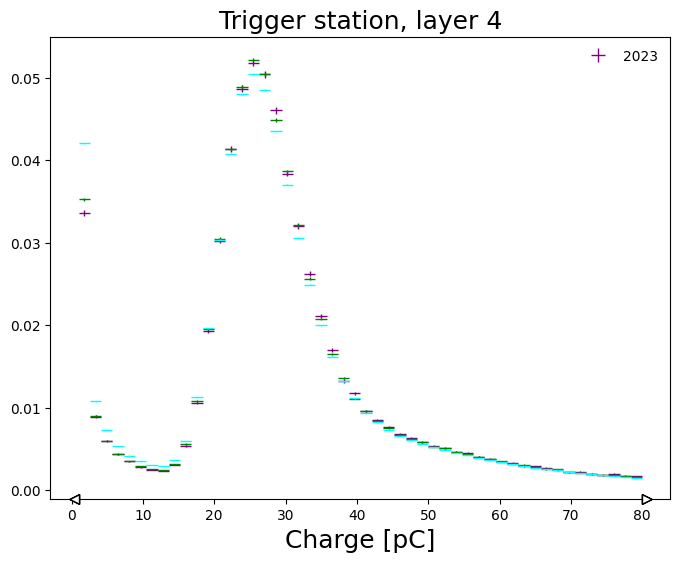

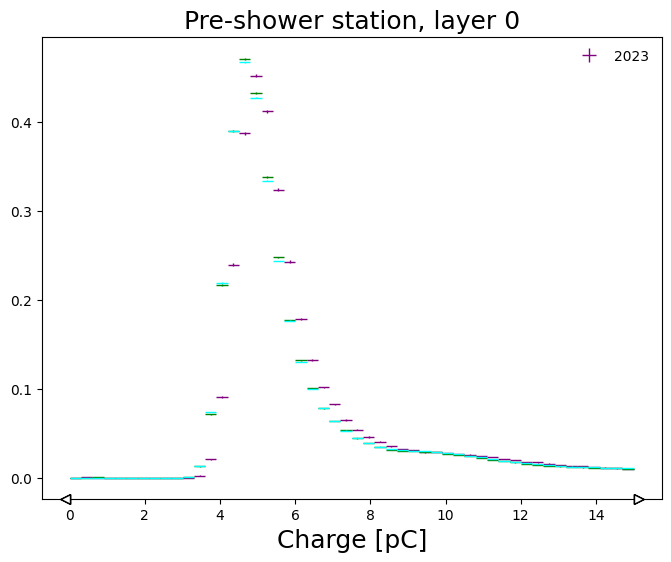

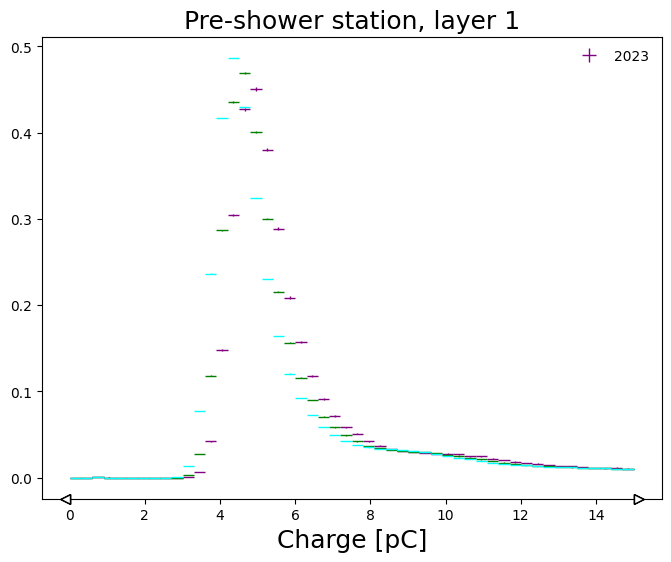

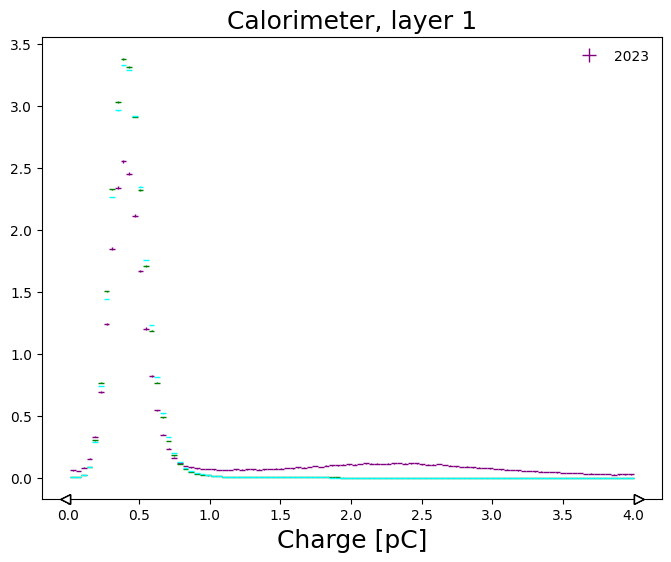

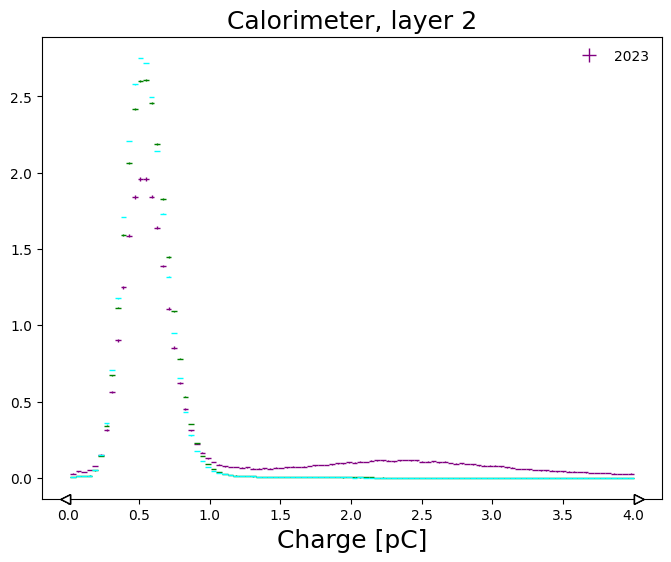

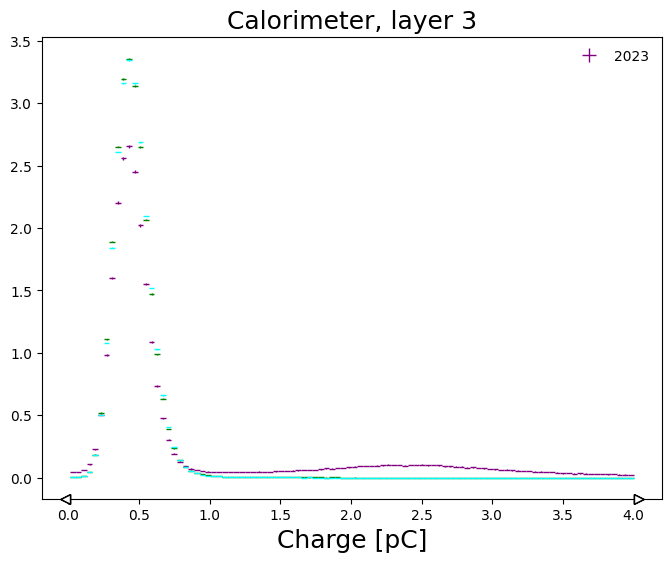

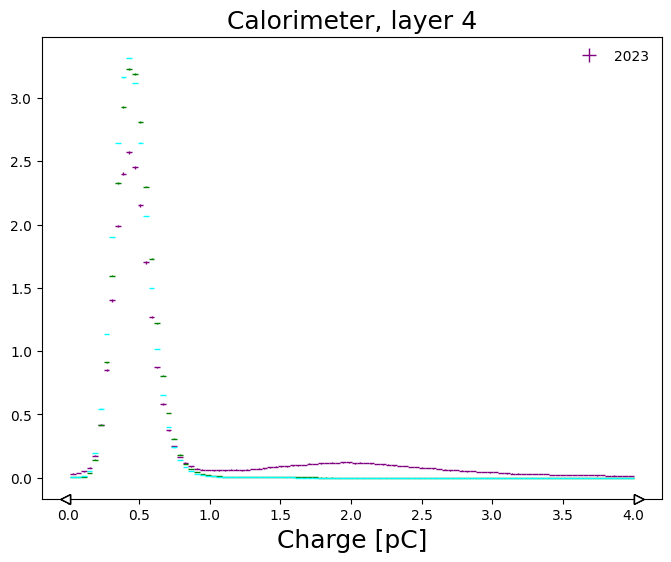

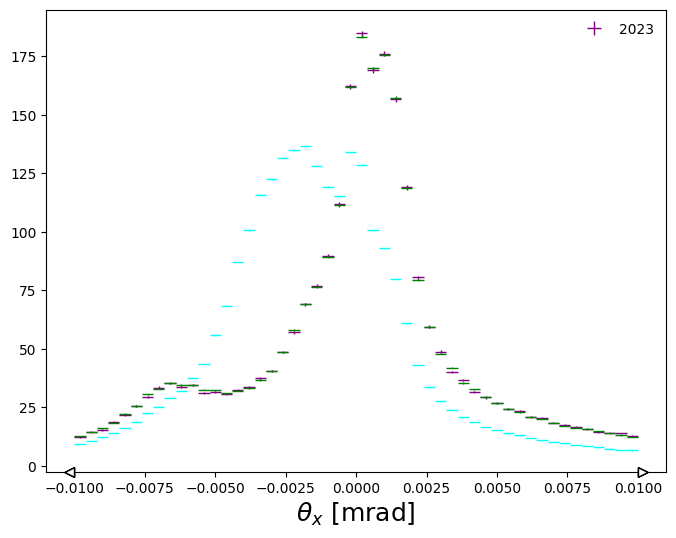

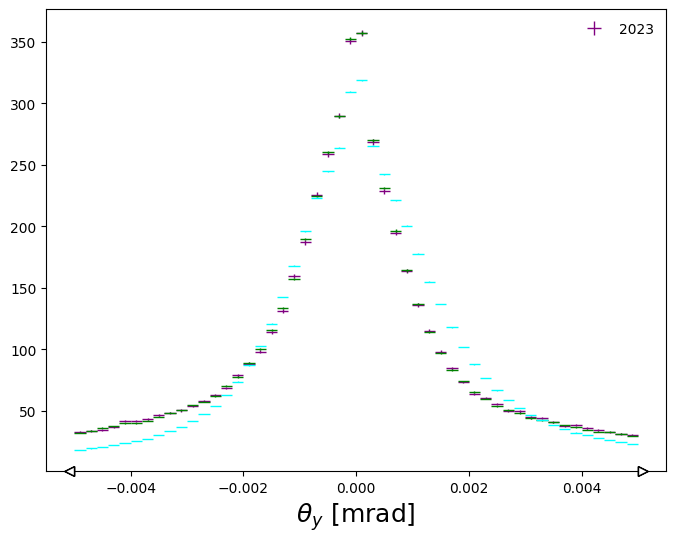

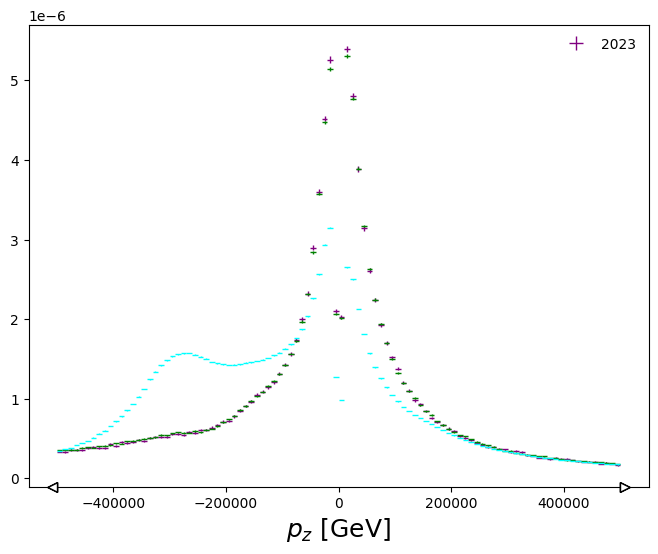

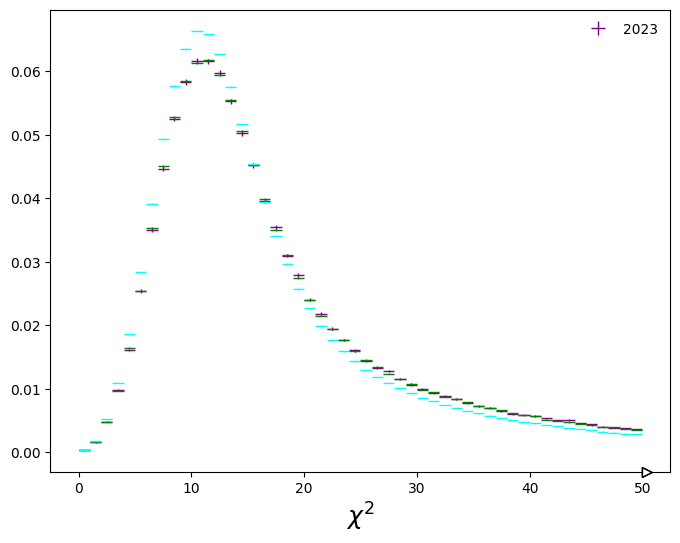

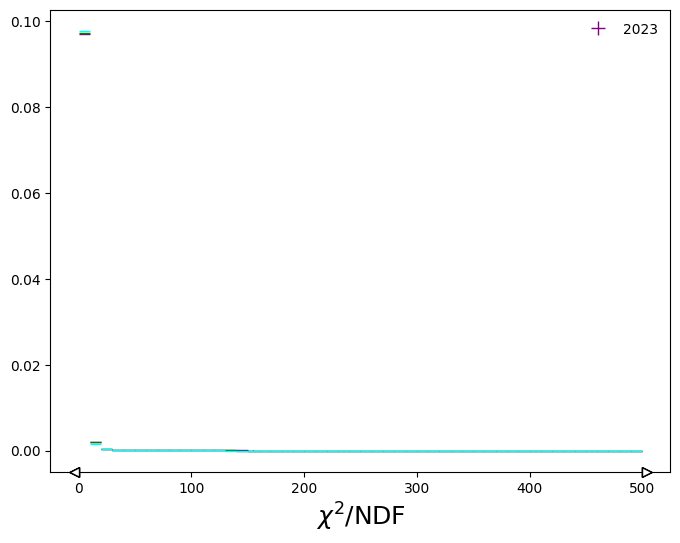

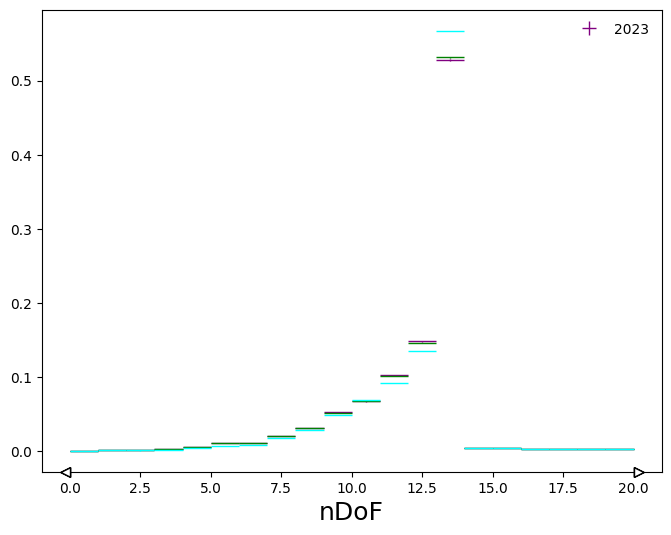

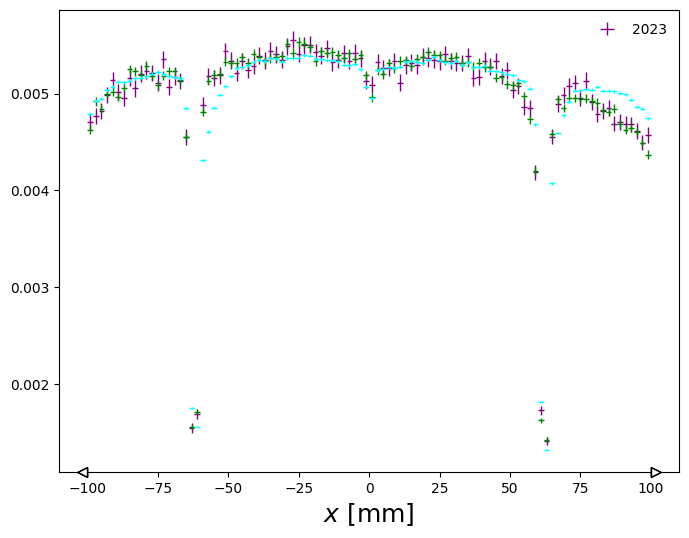

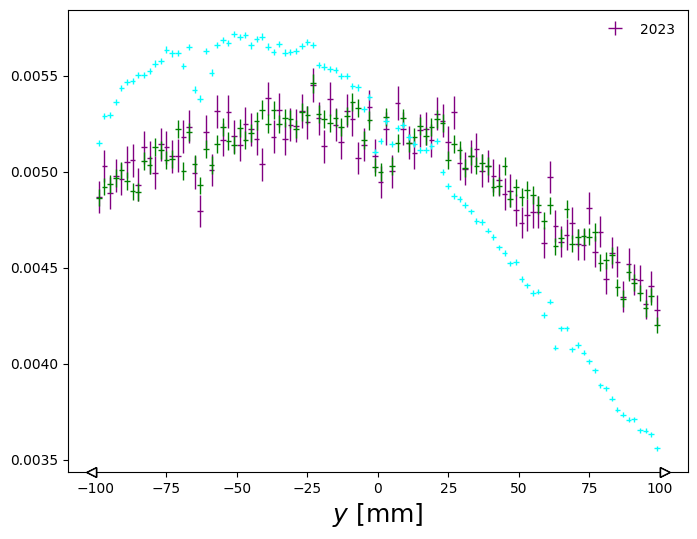

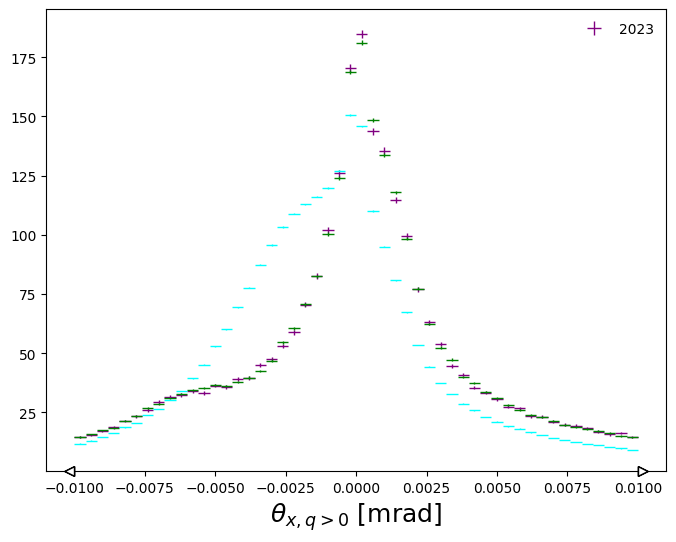

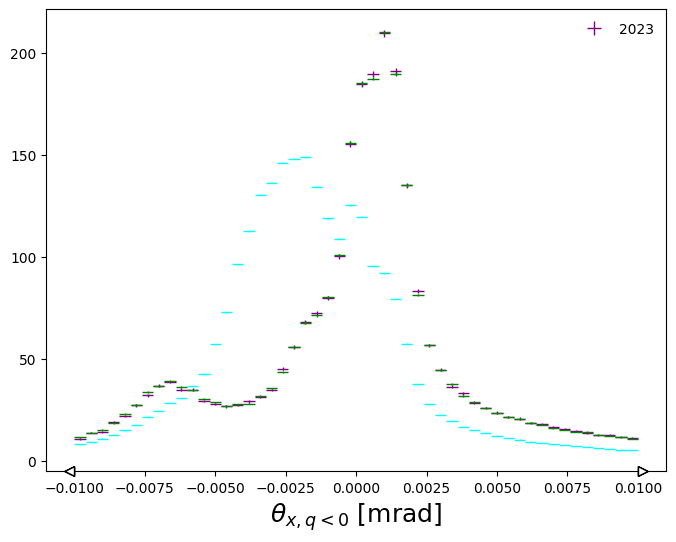

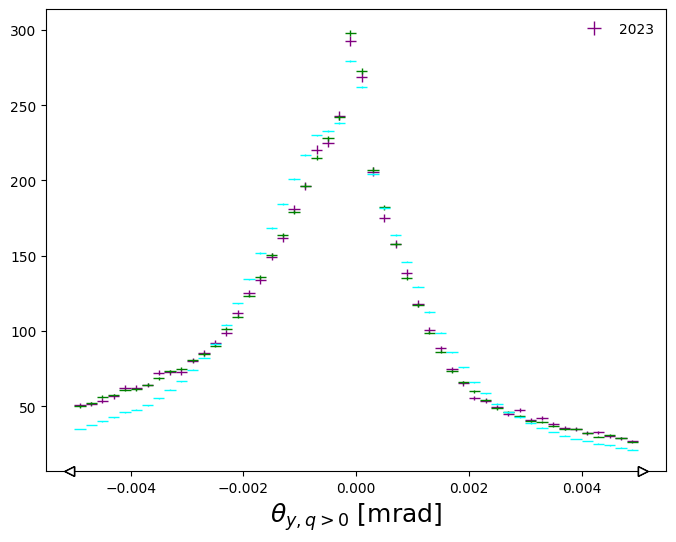

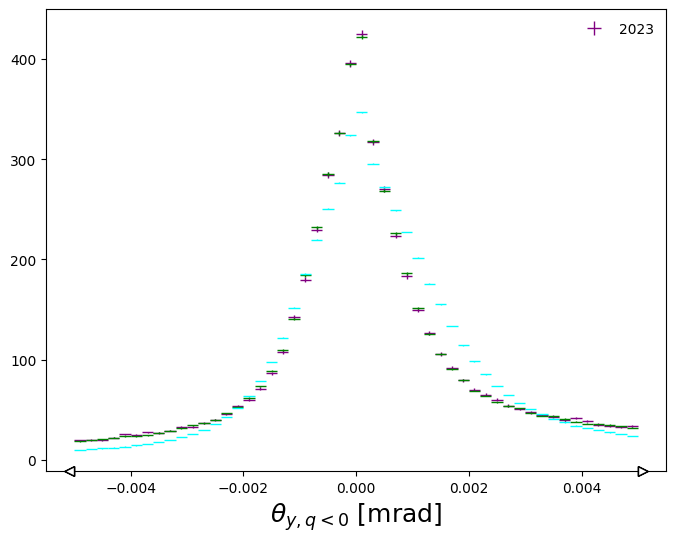

: 

In [ ]:
plot_dq_hists(files_2022, files_2023, files_2024, plotting_config, bad_runs)

In [8]:
def plot_timing_hists(files_2024, bad_runs=None):
    
    def plot_variable_for_run(ax, fpath, varname, colour='orange', year="2024"):
        data = uproot.open(fpath)
        metadata = data['dq'].arrays()
        lumi = metadata['lumi'][0]*1000
        run = np.ravel(metadata['run_number'])[0]

        if lumi < 10: return False # lumi < 10 /pb
        if run in bad_runs: return False

        hist = data[varname]
        hep.histplot(
            hist,
            histtype="errorbar",
            xerr=True,
            marker="",
            color=colour,
            label=year,
            density=True,
            ax=ax,
        )
        return True
    
    vars = ["VetoNu0_triggertime",
    "VetoNu1_triggertime",
    "VetoSt10_triggertime",
    "VetoSt11_triggertime",
    "VetoSt20_triggertime",
    "VetoSt21_triggertime",
    "Timing0_triggertime",
    "Timing1_triggertime",
    "Timing2_triggertime",
    "Timing3_triggertime",
    "Preshower0_triggertime",
    "Preshower1_triggertime",
    "CaloLo0_triggertime",
    "CaloLo1_triggertime",
    "CaloLo2_triggertime",
    "CaloLo3_triggertime",
    "CaloHi0_triggertime",
    "CaloHi1_triggertime",
    "CaloHi2_triggertime",
    "CaloHi3_triggertime",
    "VetoNu0_localtime",
    "VetoNu1_localtime",
    "VetoSt10_localtime",
    "VetoSt11_localtime",
    "VetoSt20_localtime",
    "VetoSt21_localtime",
    "Timing0_localtime",
    "Timing1_localtime",
    "Timing2_localtime",
    "Timing3_localtime",
    "Preshower0_localtime",
    "Preshower1_localtime",
    "CaloLo0_localtime",
    "CaloLo1_localtime",
    "CaloLo2_localtime",
    "CaloLo3_localtime",
    "CaloHi0_localtime",
    "CaloHi1_localtime",
    "CaloHi2_localtime",
    "CaloHi3_localtime",
    "VetoNu0_bcidtime",
    "VetoNu1_bcidtime",
    "VetoSt10_bcidtime",
    "VetoSt11_bcidtime",
    "VetoSt20_bcidtime",
    "VetoSt21_bcidtime",
    "Timing0_bcidtime",
    "Timing1_bcidtime",
    "Timing2_bcidtime",
    "Timing3_bcidtime",
    "Preshower0_bcidtime",
    "Preshower1_bcidtime",
    "CaloLo0_bcidtime",
    "CaloLo1_bcidtime",
    "CaloLo2_bcidtime",
    "CaloLo3_bcidtime",
    "CaloHi0_bcidtime",
    "CaloHi1_bcidtime",
    "CaloHi2_bcidtime",
    "CaloHi3_bcidtime",]


    for varname in vars:
        fig, ax = plt.subplots(figsize=(8, 6))
        # for fpath in files_2022: plot_variable_for_run(ax, fpath, cfg, 'red', '2022')
        # for fpath in files_2023: plot_variable_for_run(ax, fpath, cfg, 'blue', '2023')
        for fpath in files_2024: 
            run = int(os.path.basename(fpath).replace(".root", ""))
            
            if 14399 <= run <= 15026: plot_variable_for_run(ax, fpath, varname, 'orange', 'F241')
            if 15030 <= run <= 15594: plot_variable_for_run(ax, fpath, varname, 'blue', 'Tungsten')
            if 15652 <= run <= 15820: plot_variable_for_run(ax, fpath, varname, 'green', 'F242')
            if 15821 <= run <= 16924: plot_variable_for_run(ax, fpath, varname, 'purple', 'CaloNu')
            if 16928 <= run <= 17230: plot_variable_for_run(ax, fpath, varname, 'red', 'F43')

            


        ax.set_xlabel(varname, fontsize=18)
        ax.set_title(varname, fontsize=18)
        legend(ax)
        plt.savefig(f"{varname}.png", dpi=300)
        plt.show()


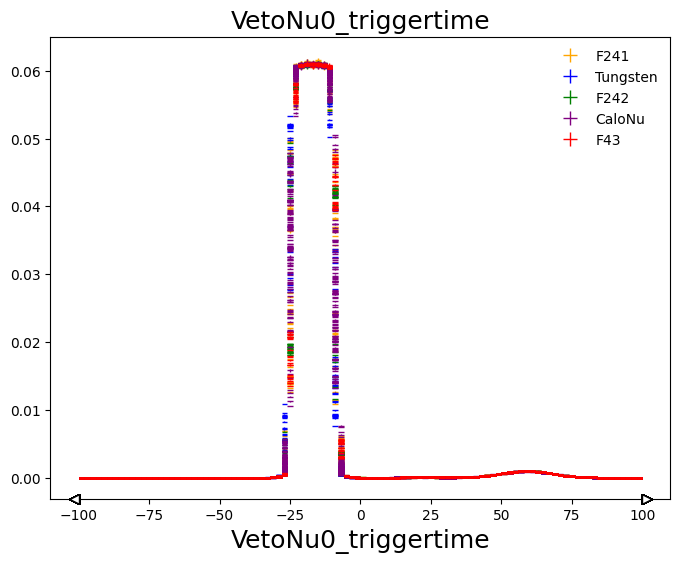

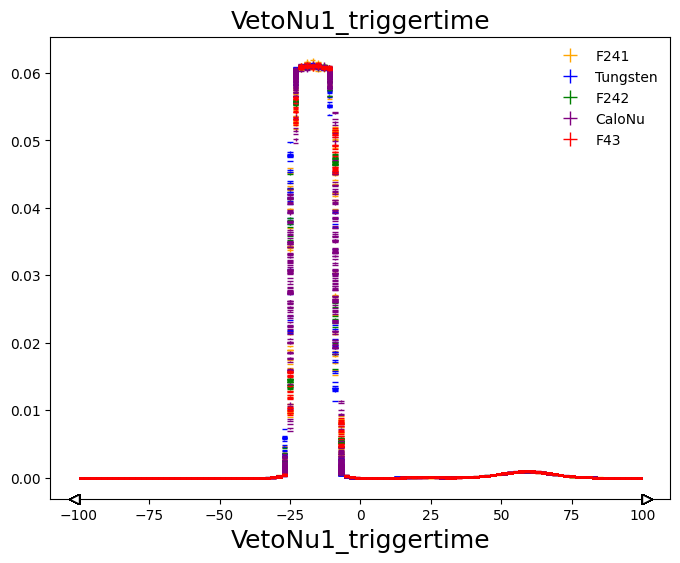

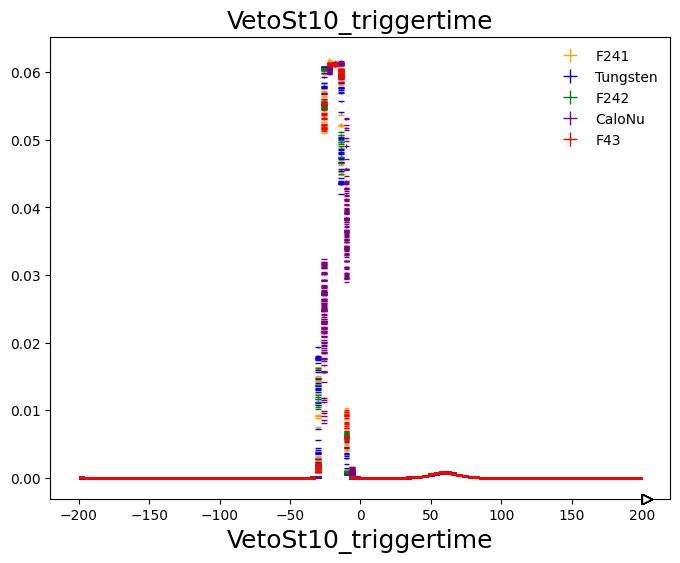

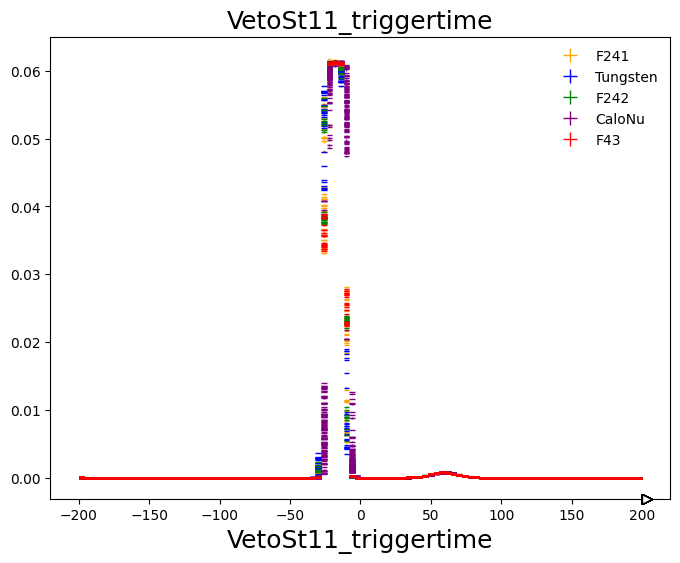

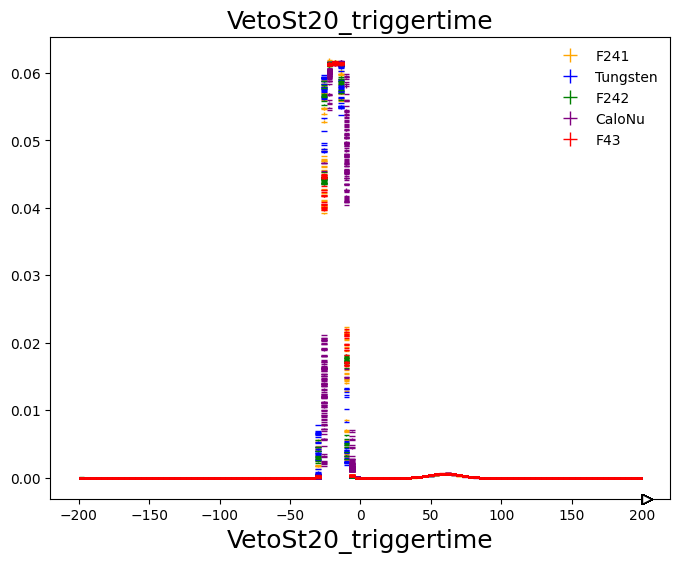

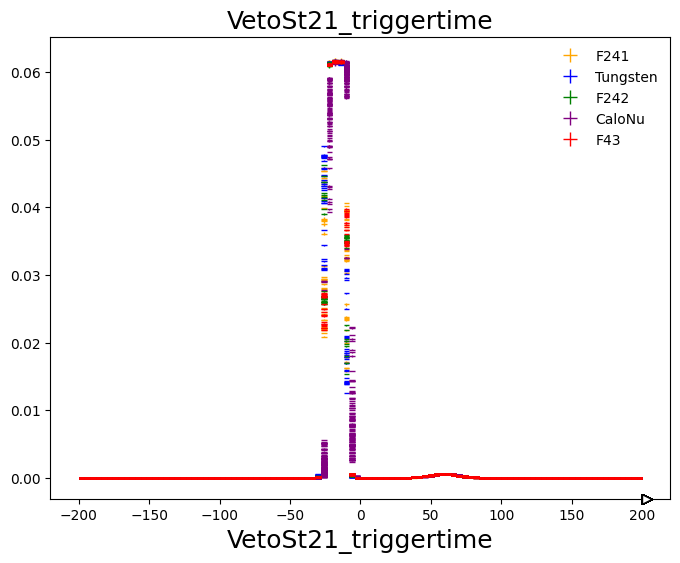

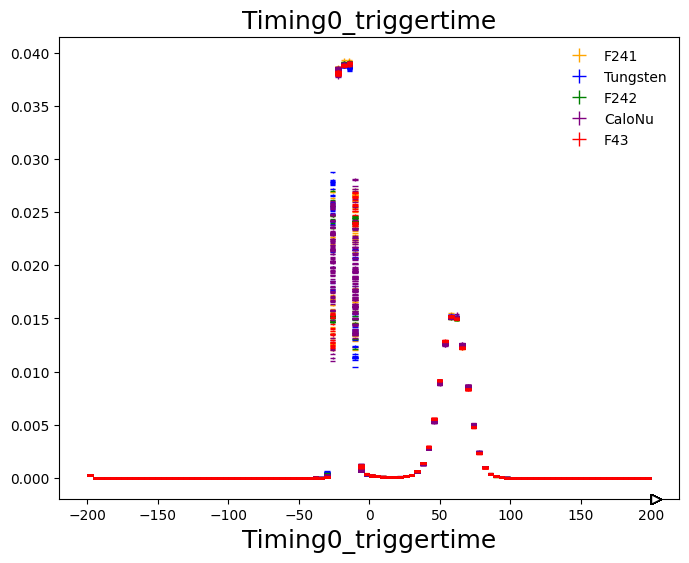

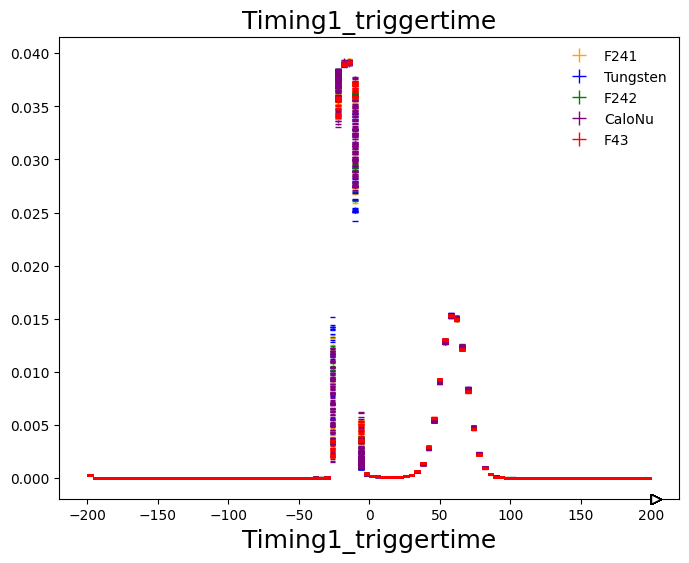

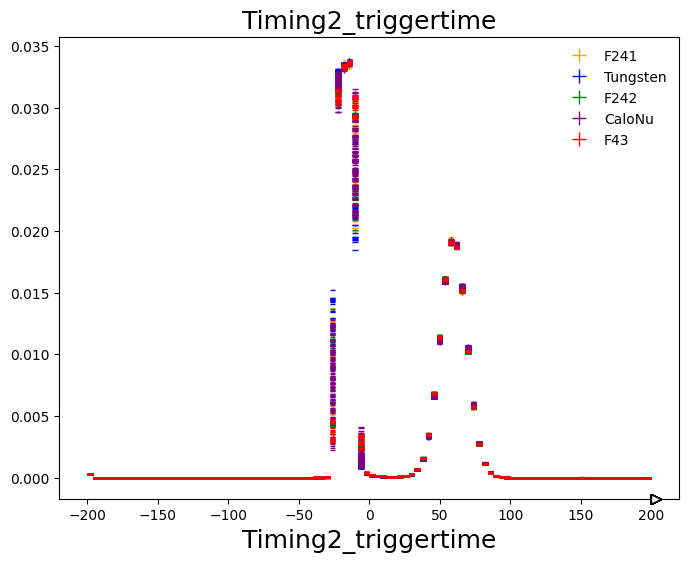

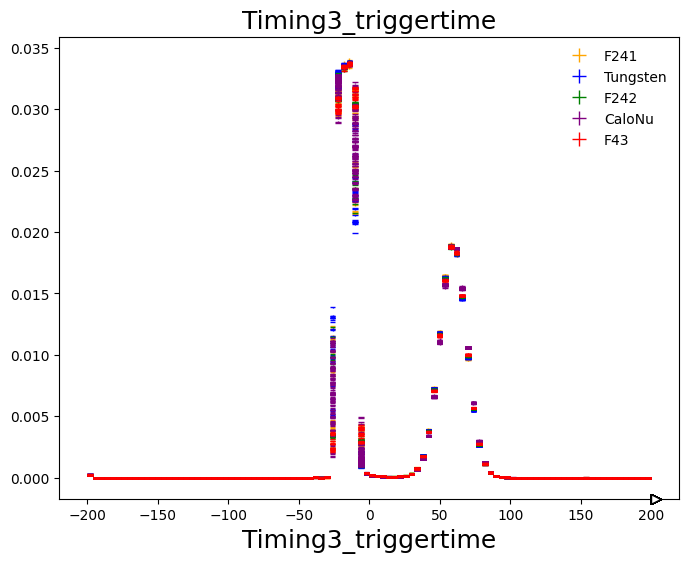

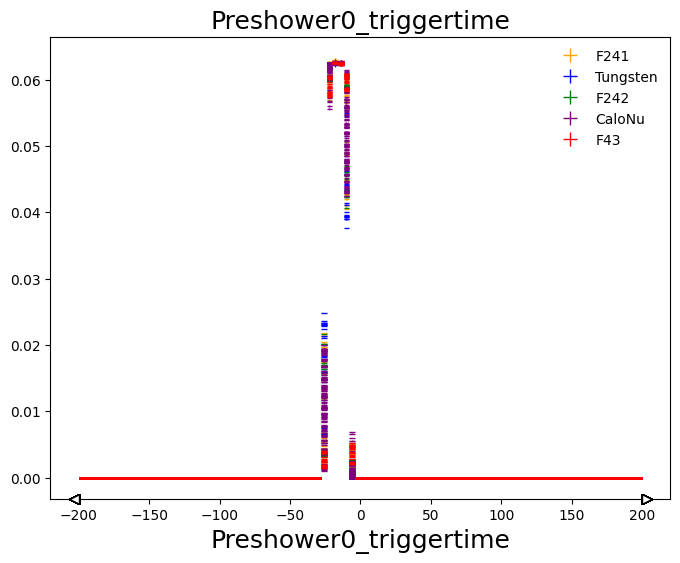

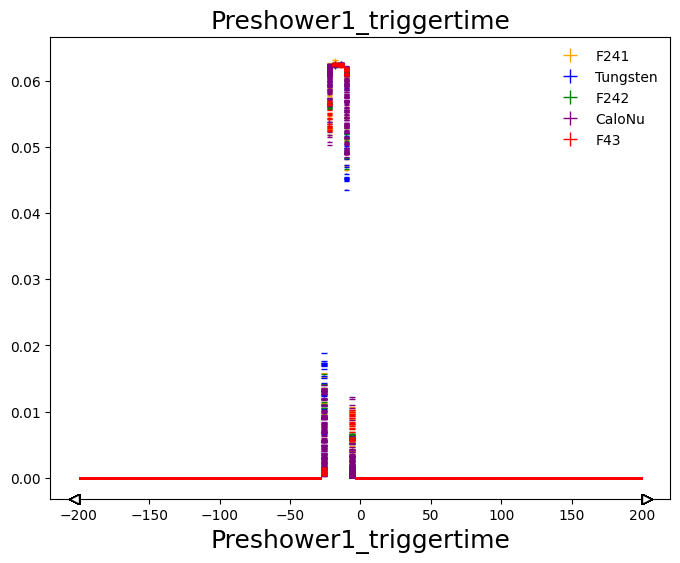

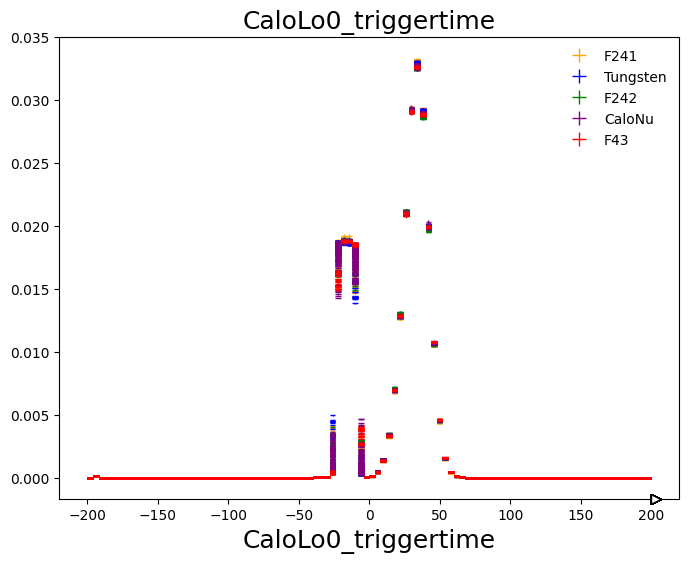

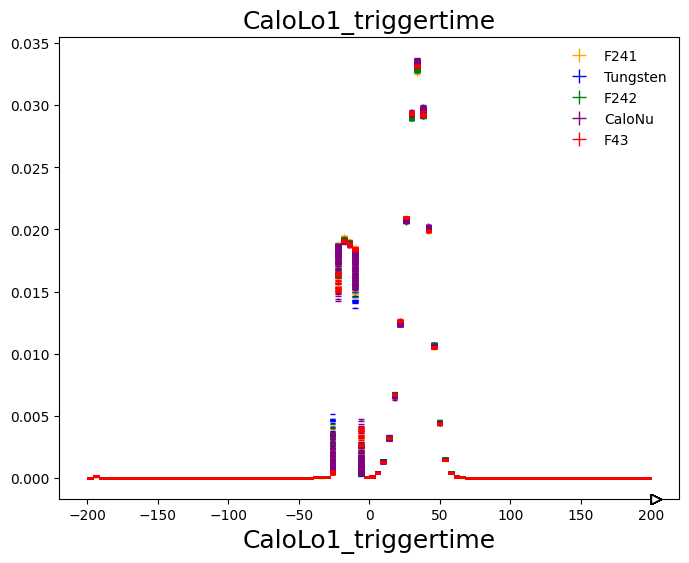

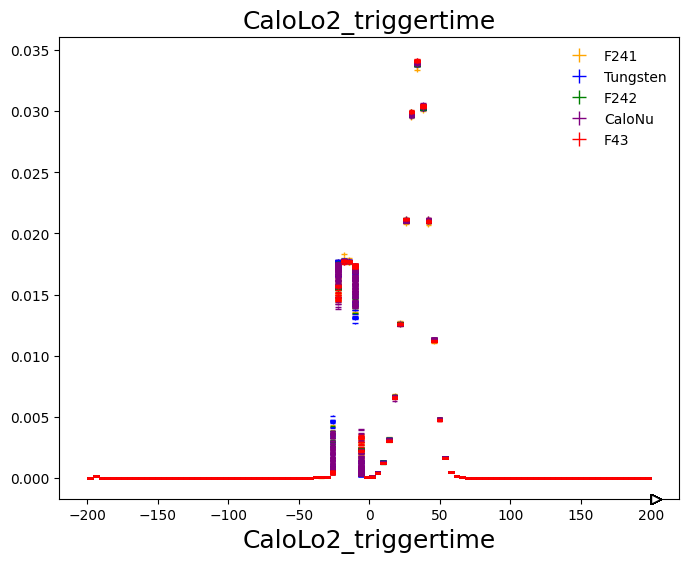

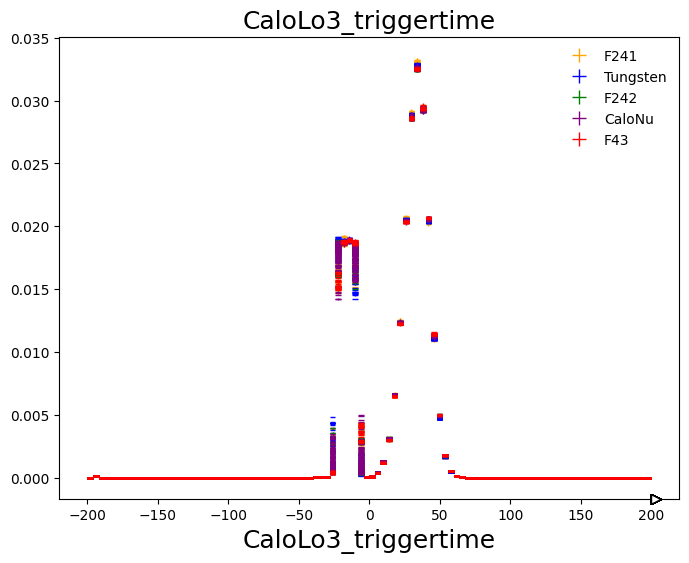

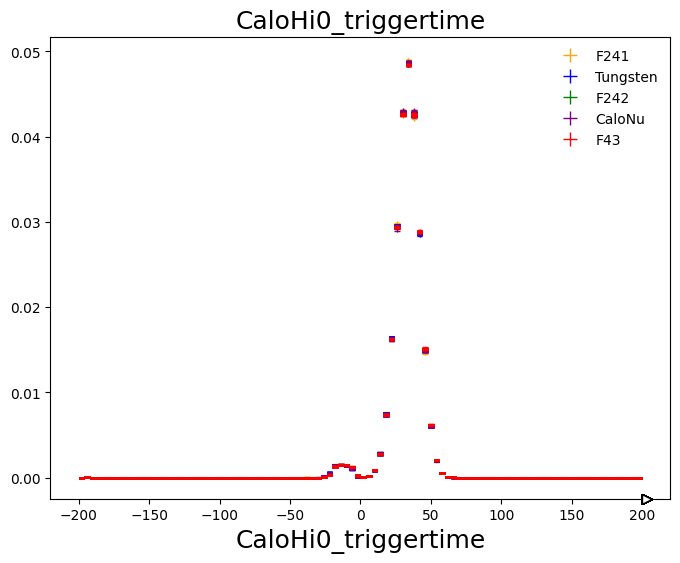

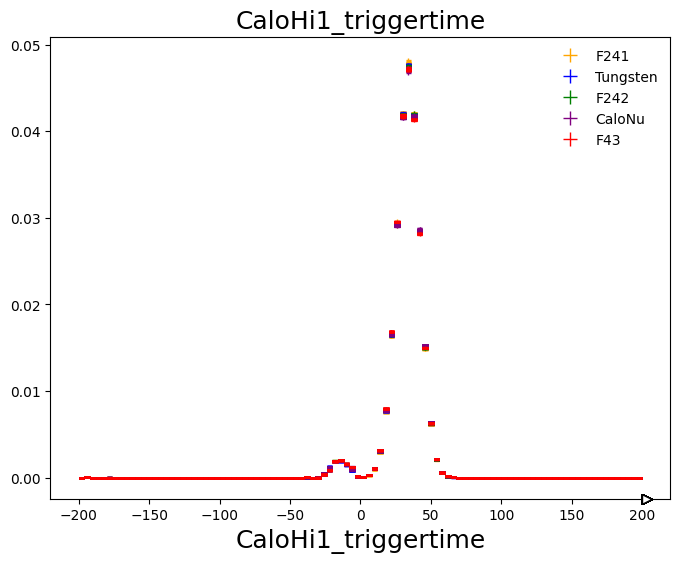

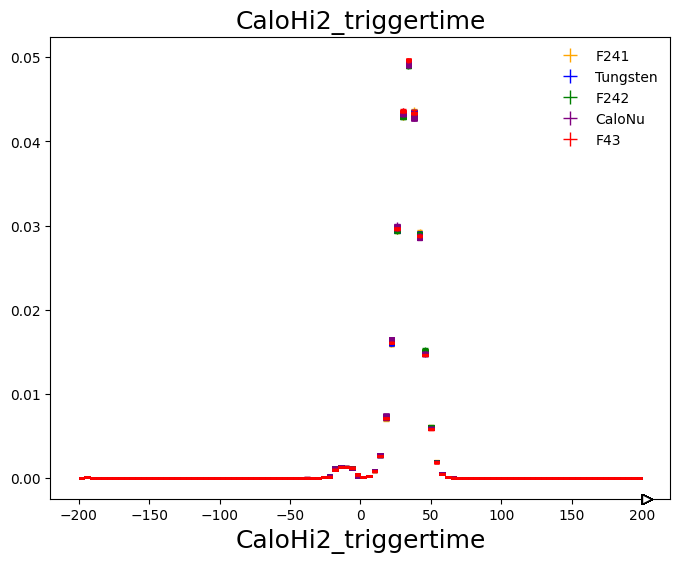

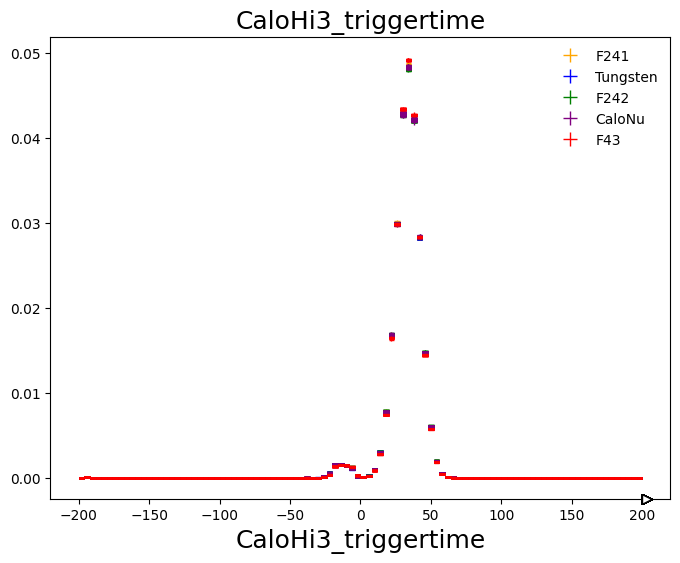

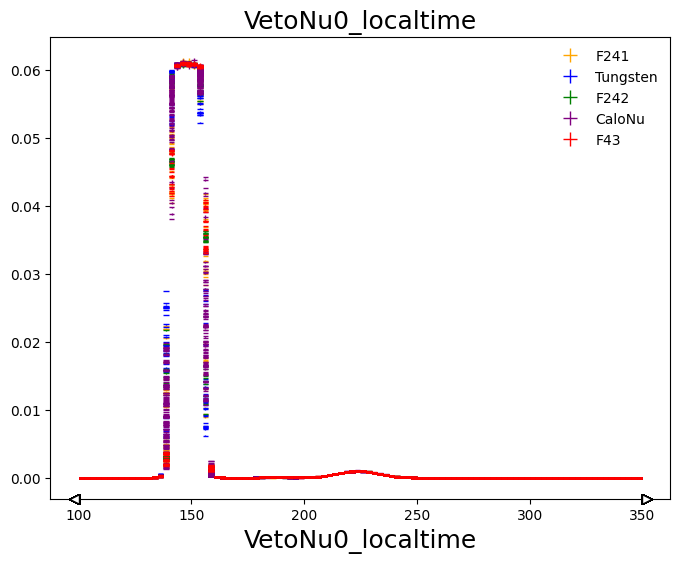

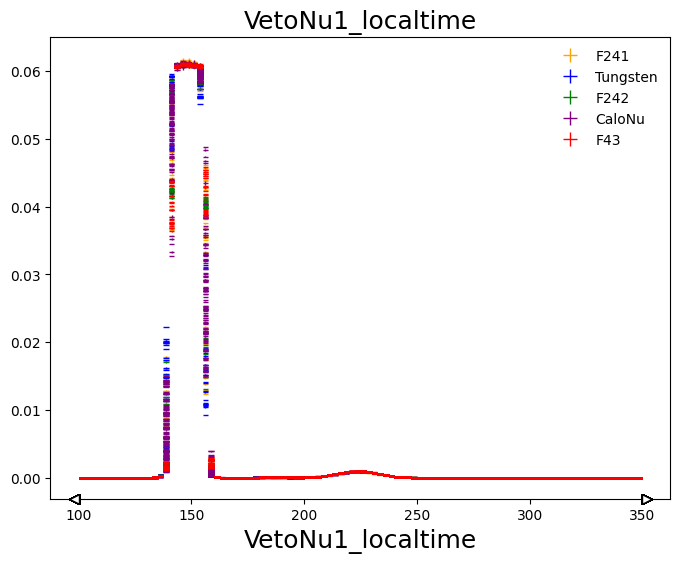

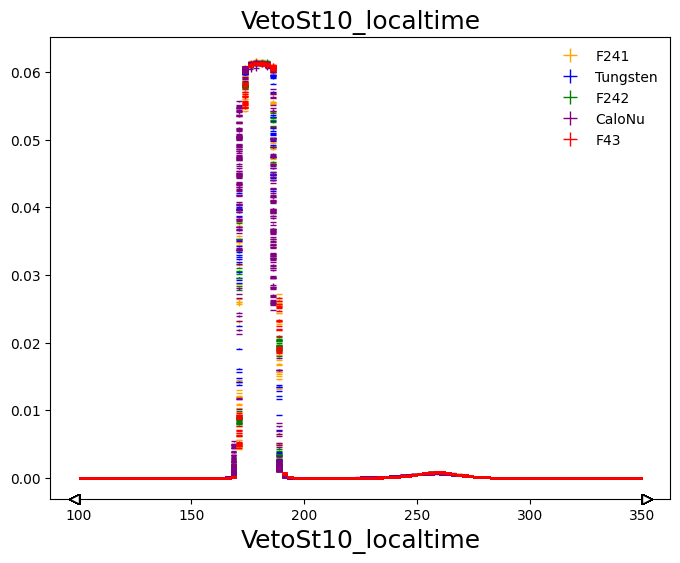

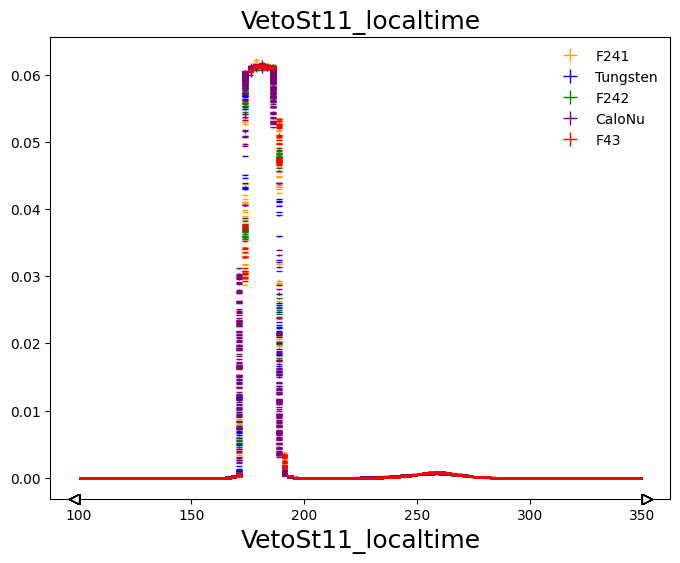

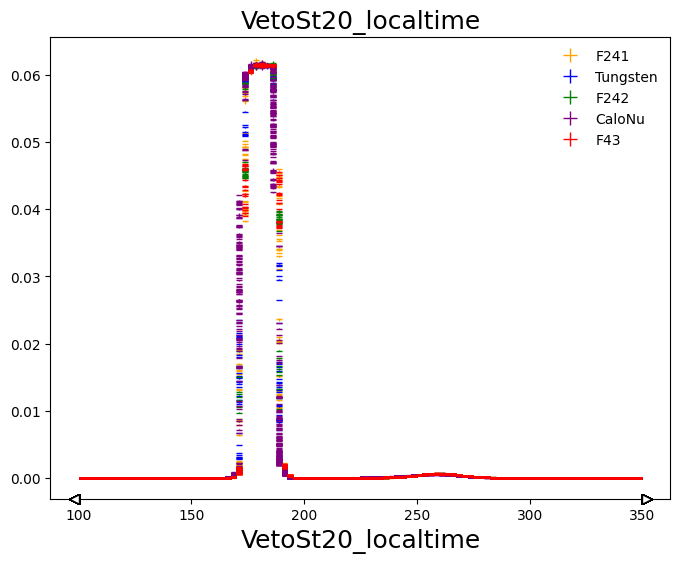

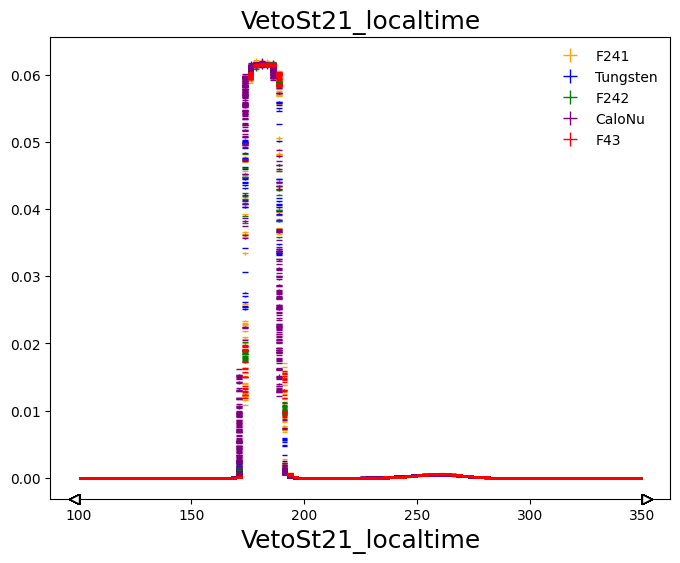

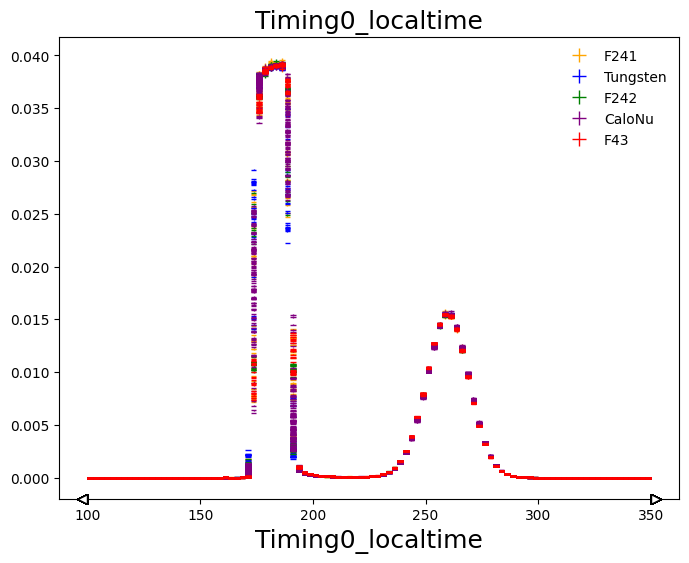

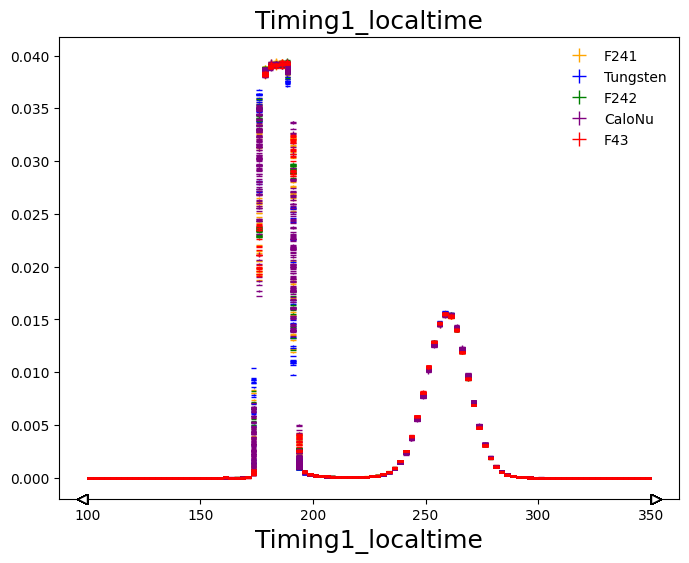

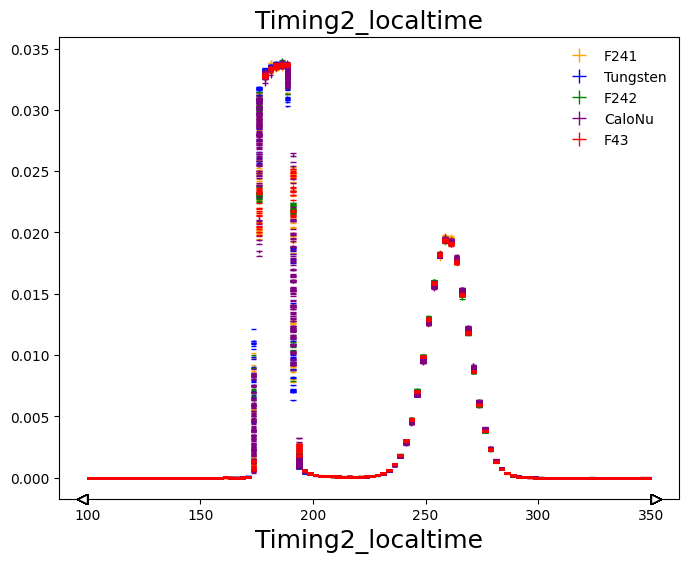

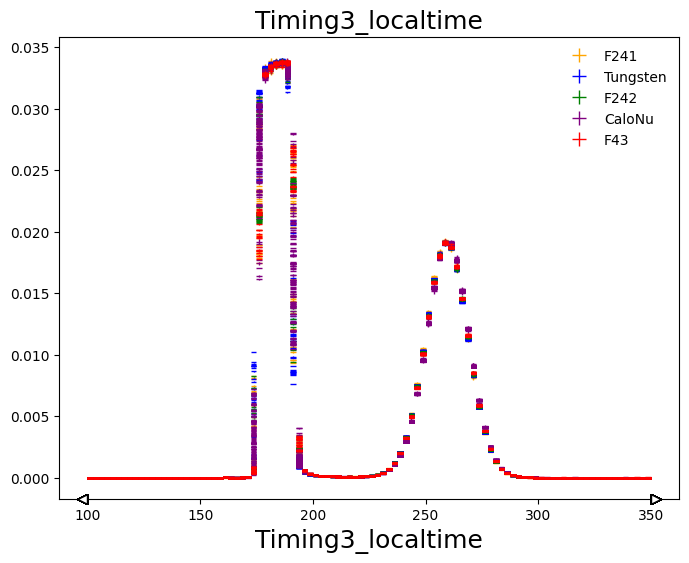

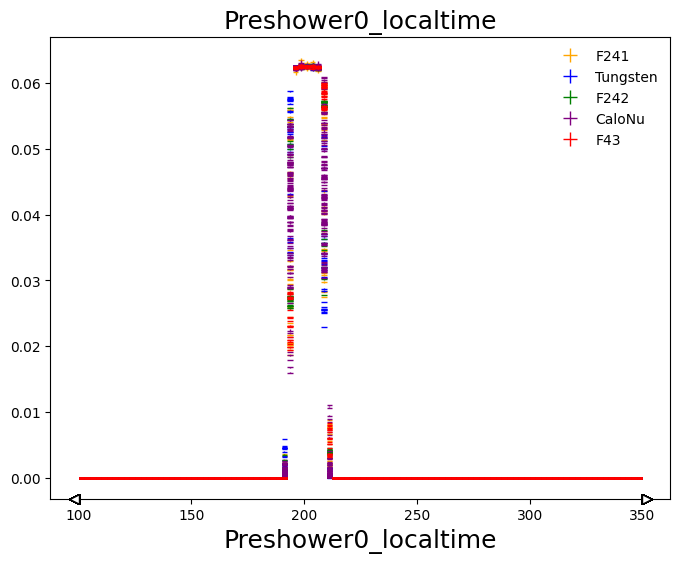

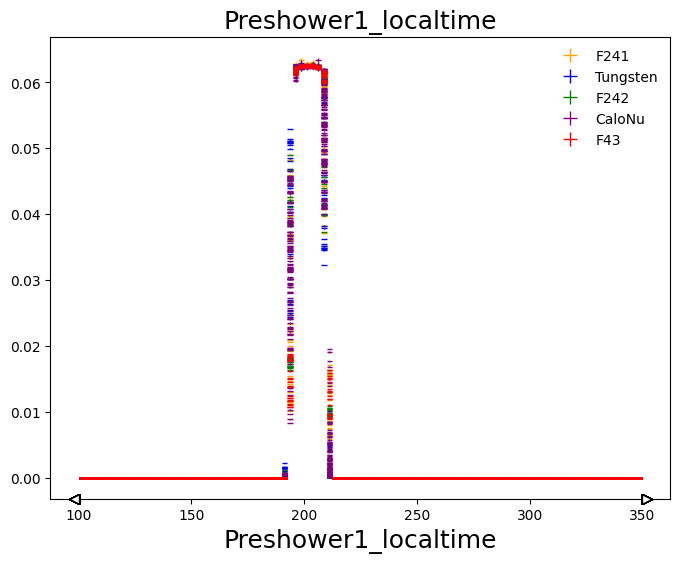

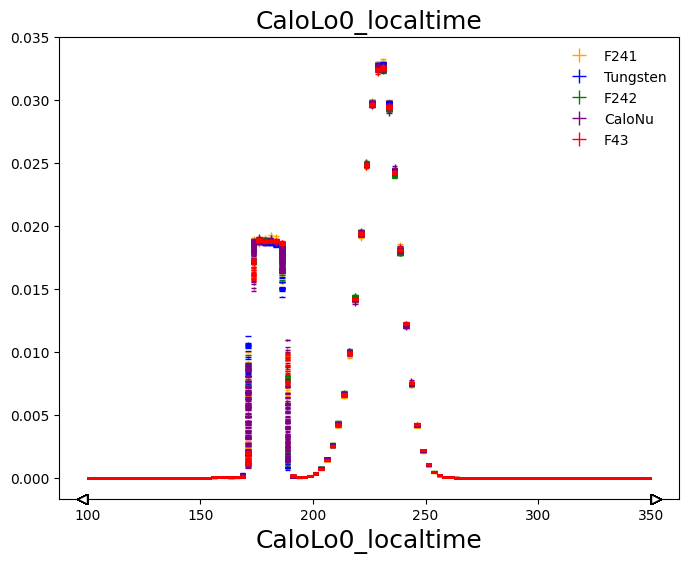

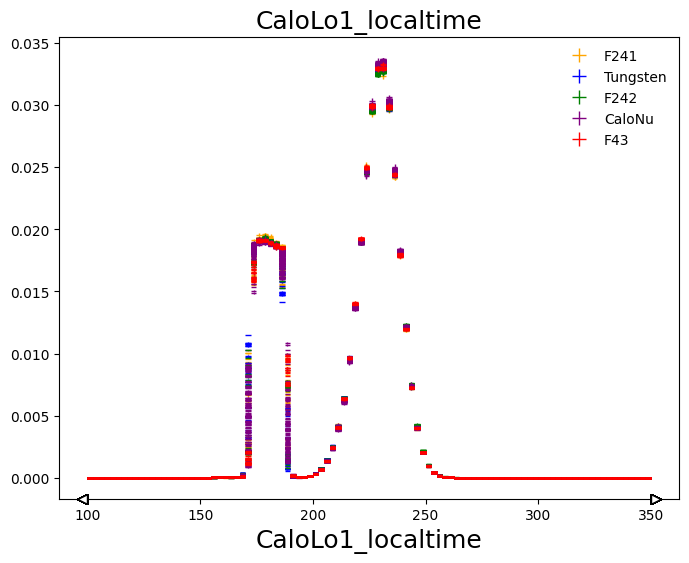

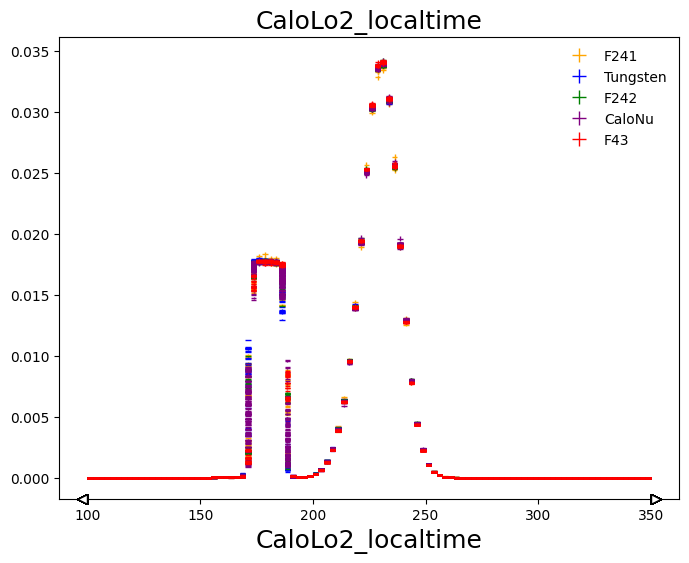

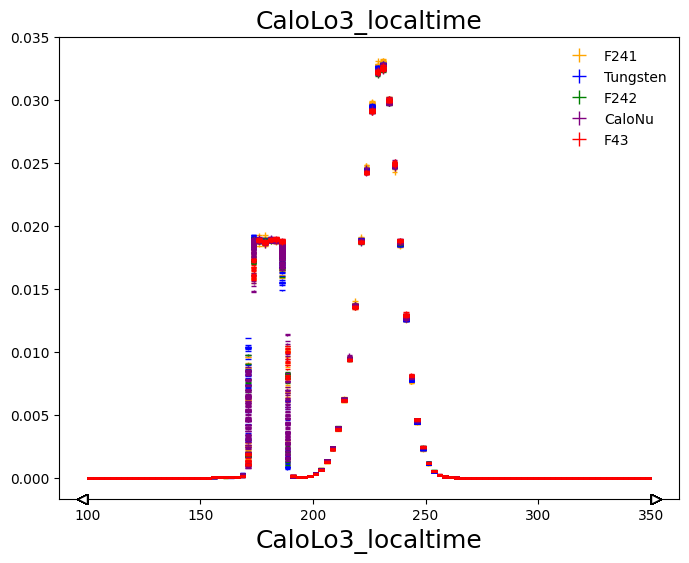

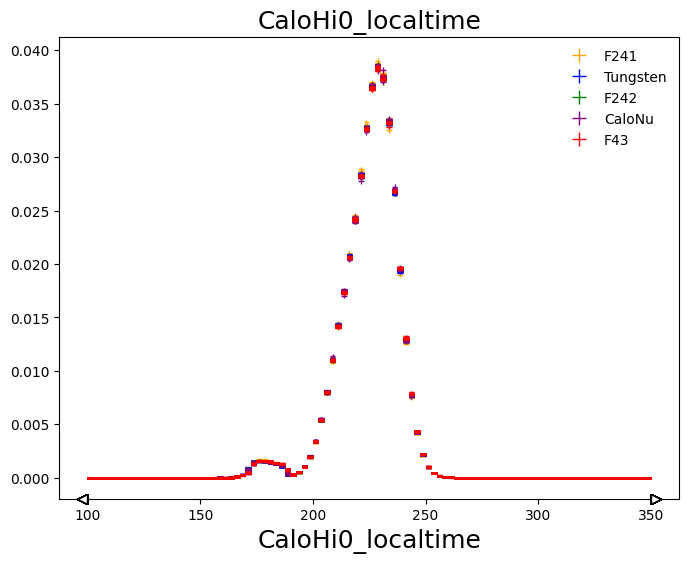

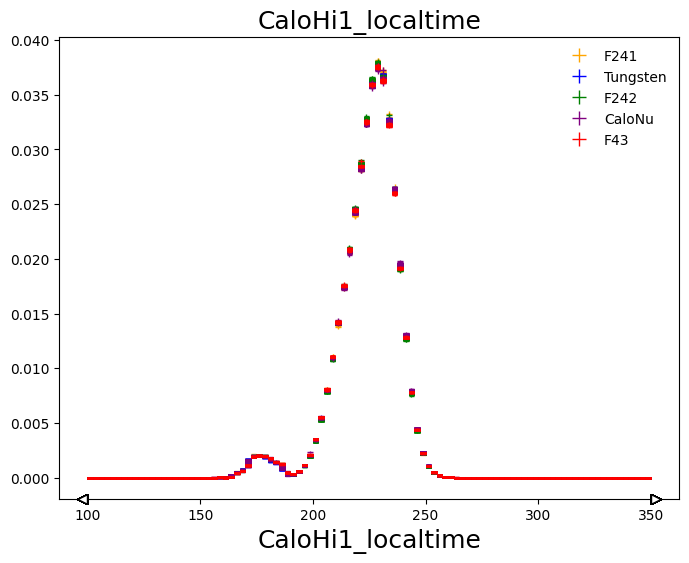

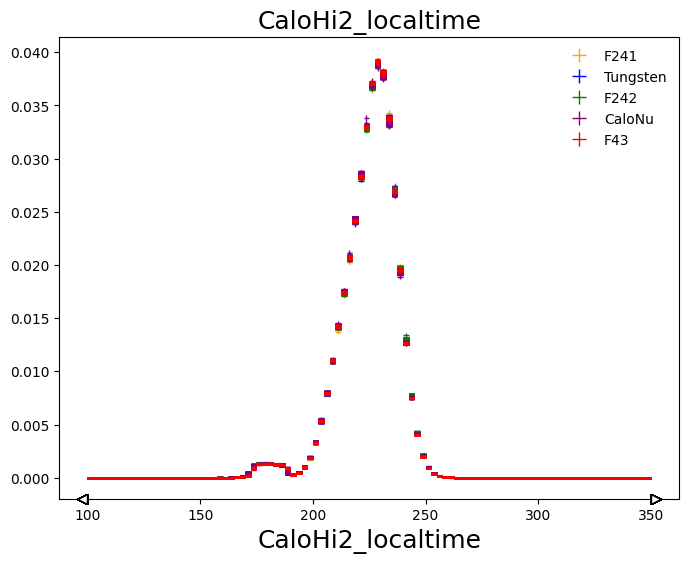

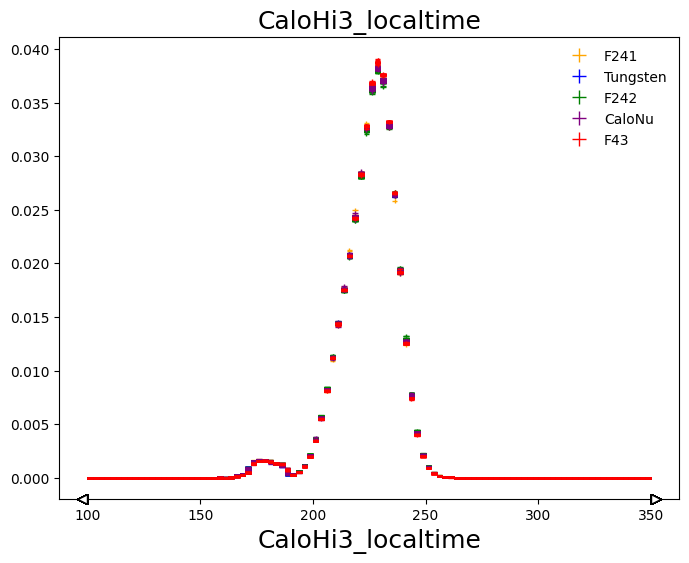

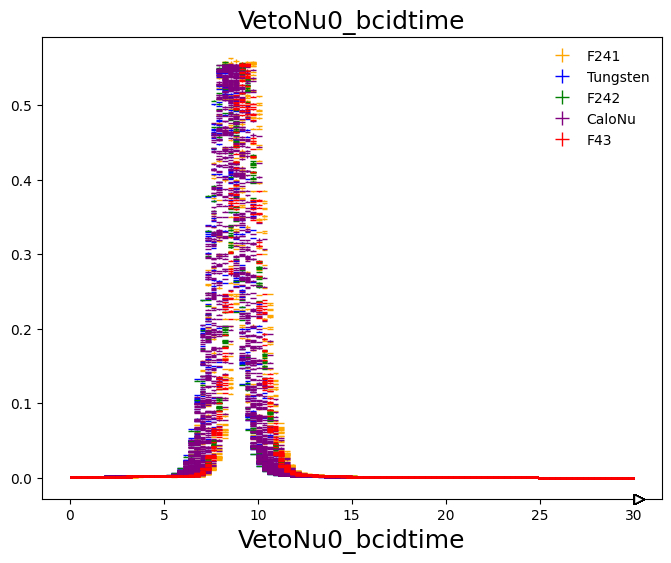

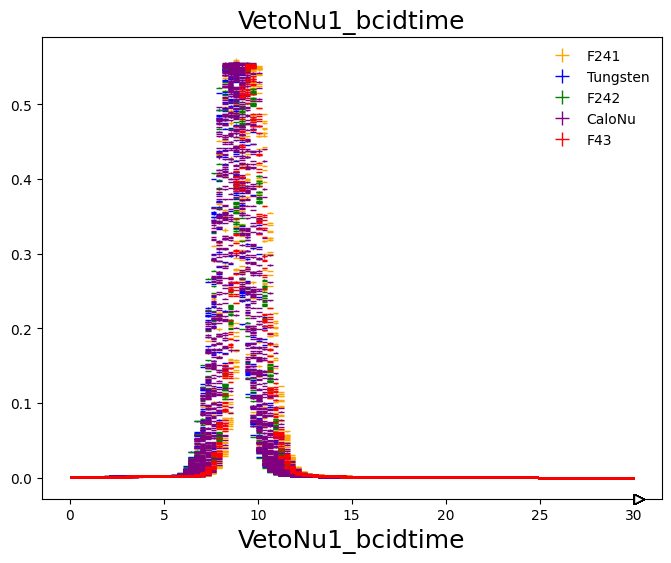

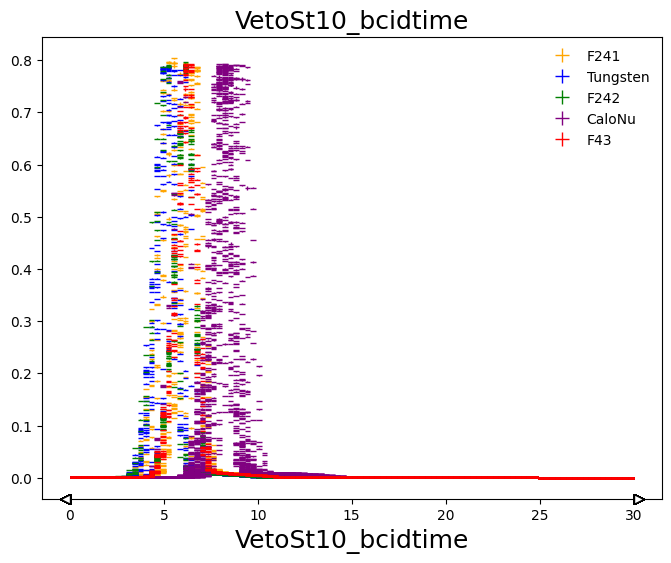

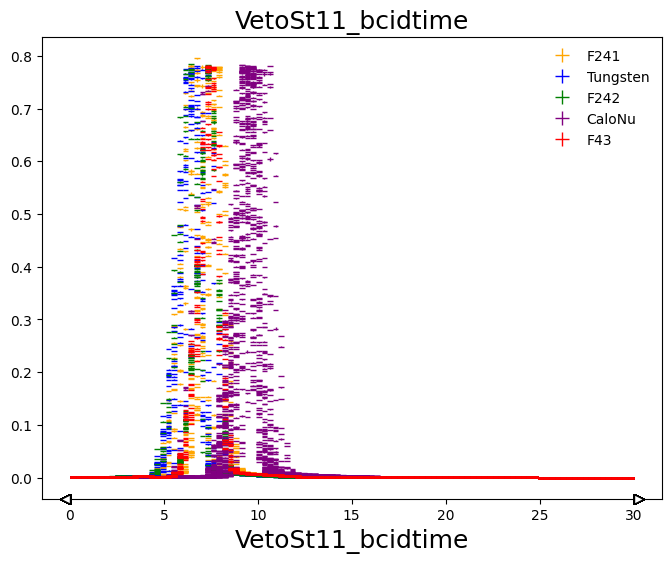

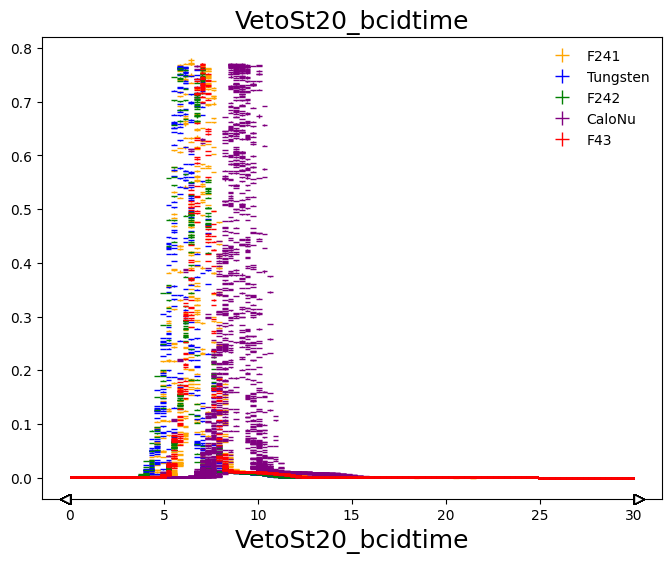

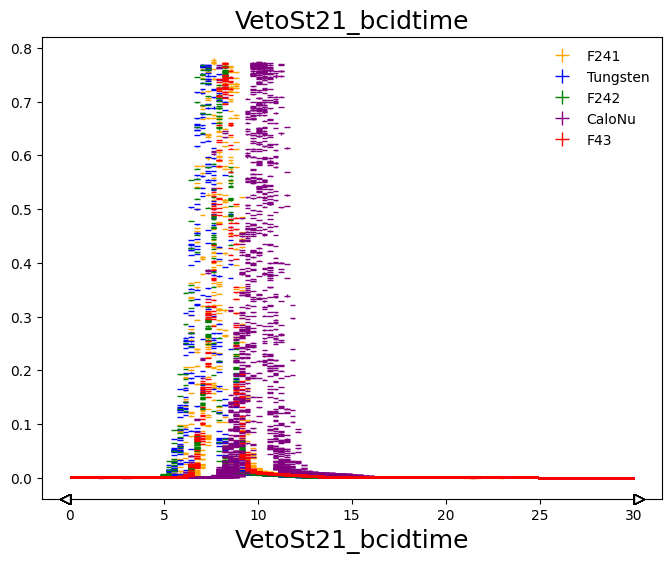

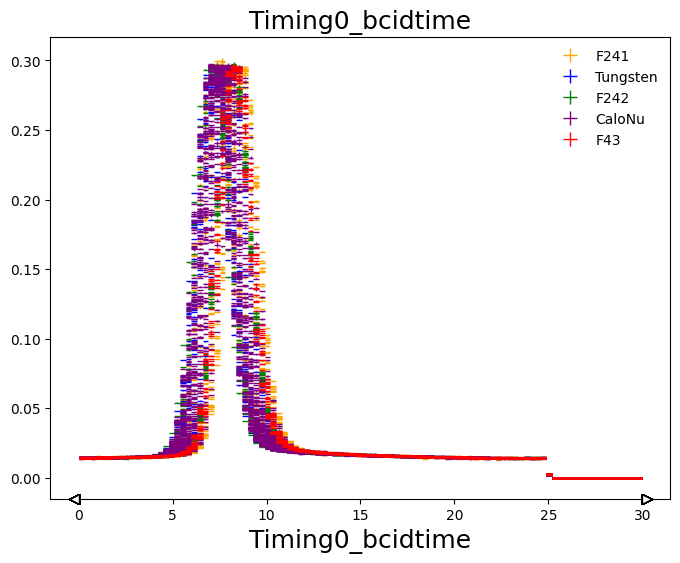

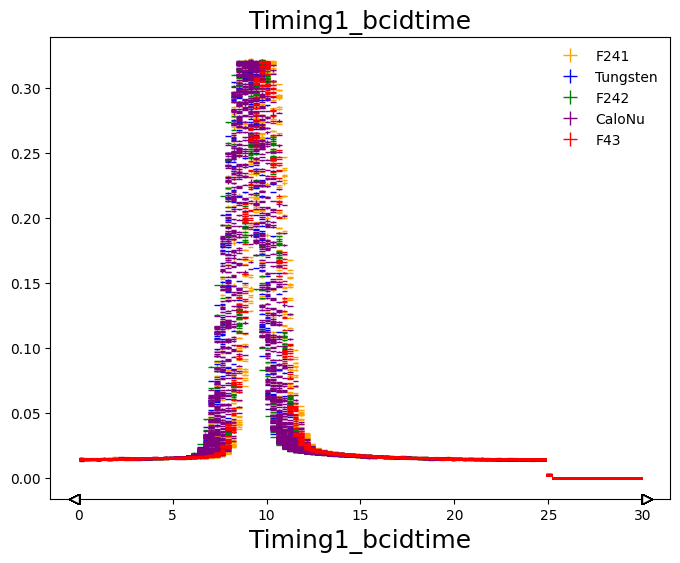

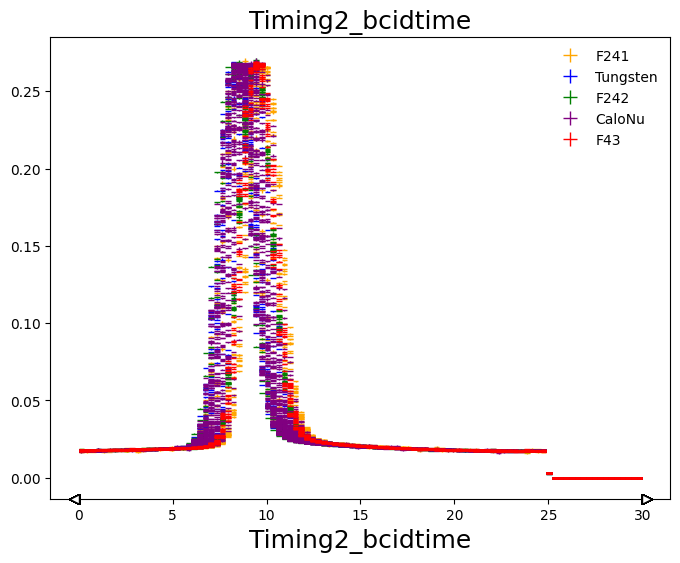

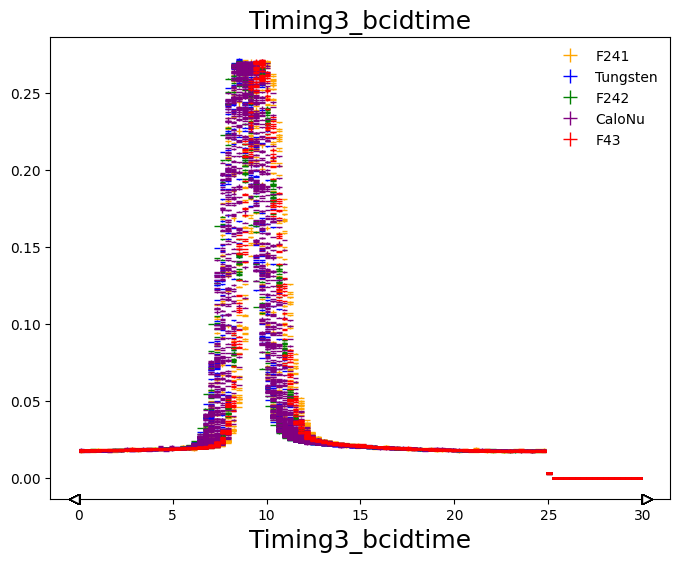

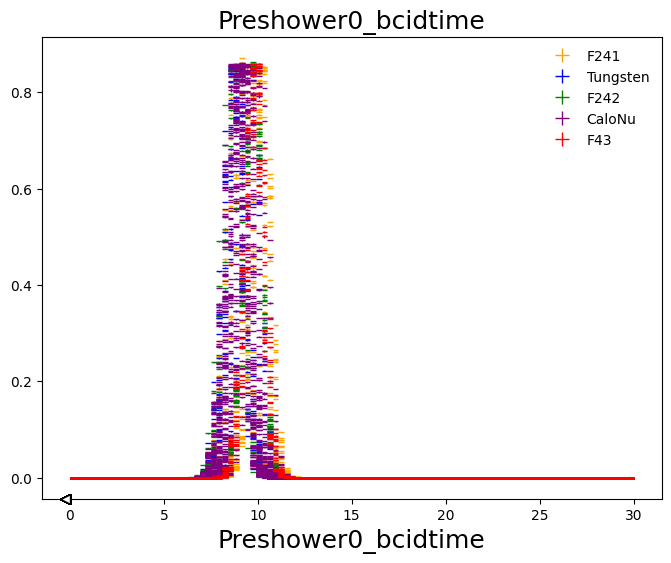

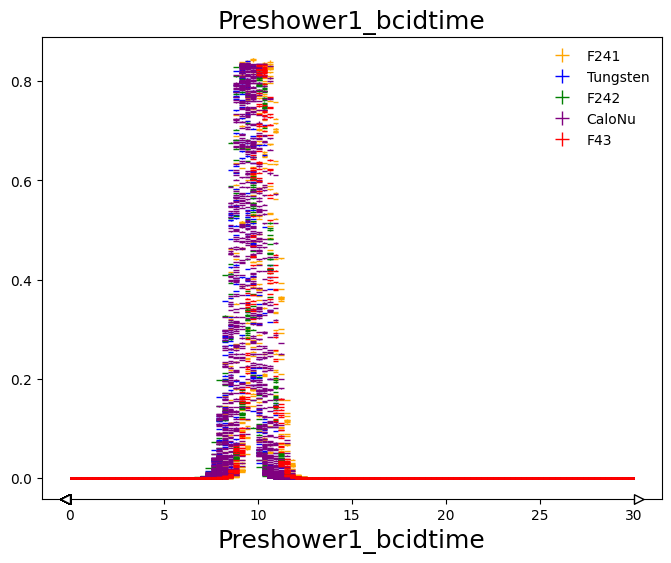

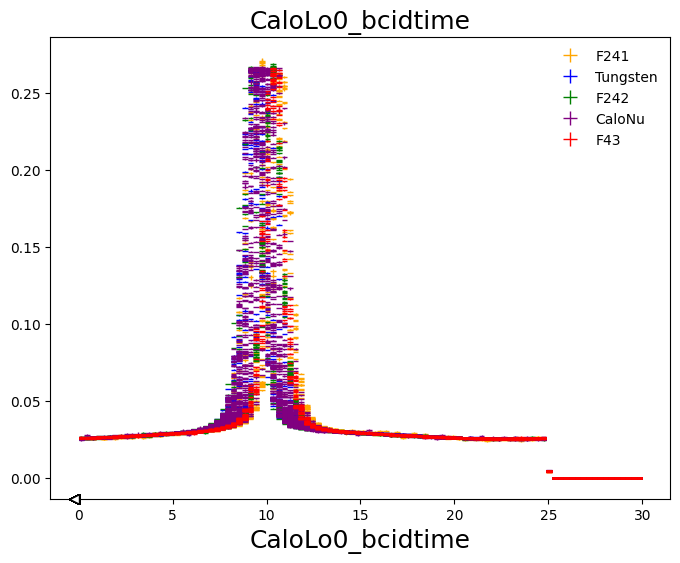

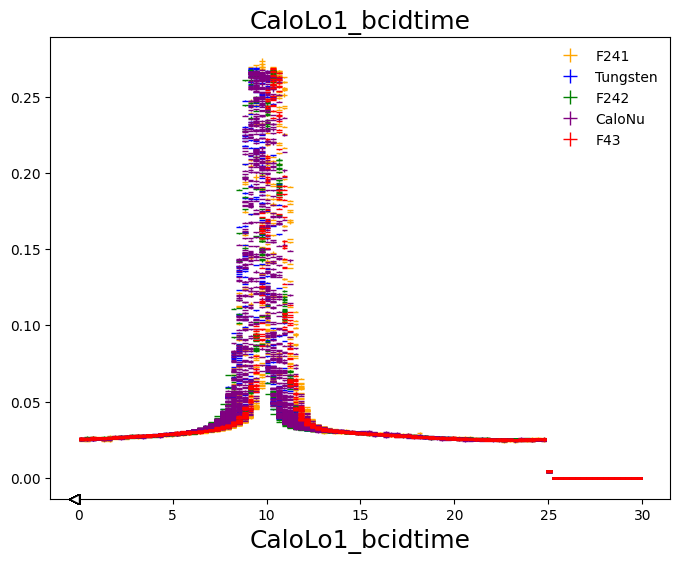

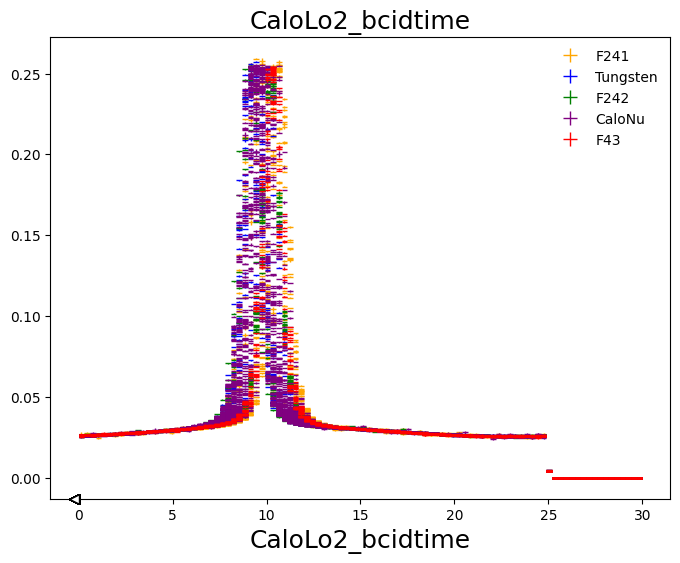

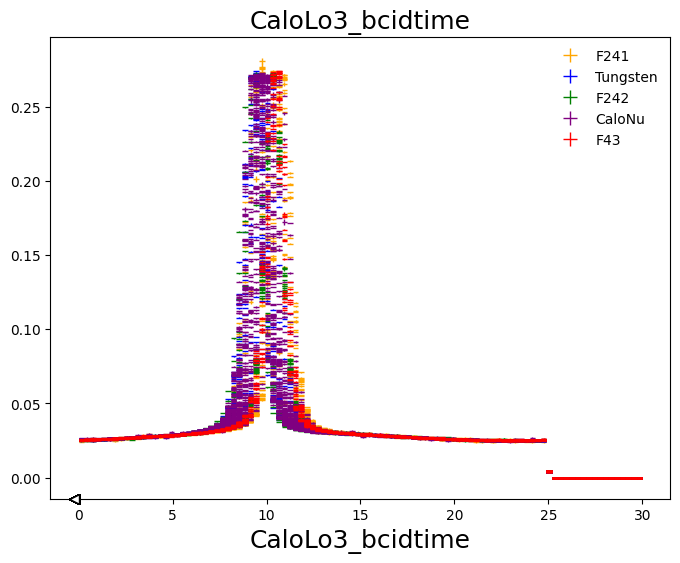

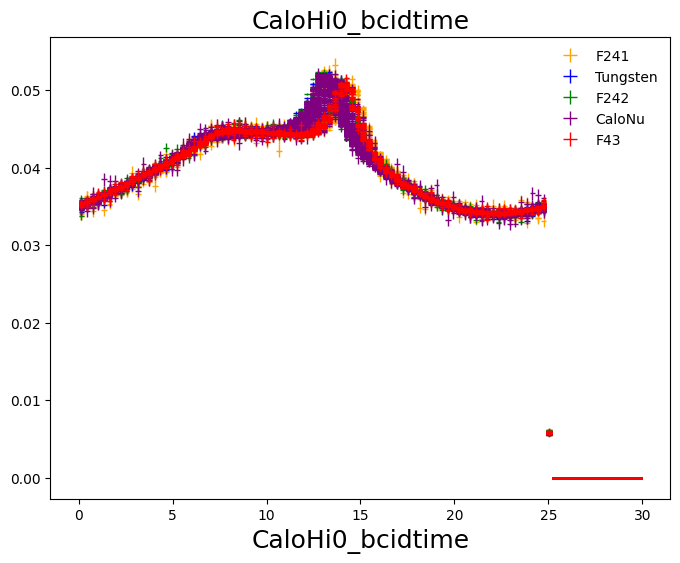

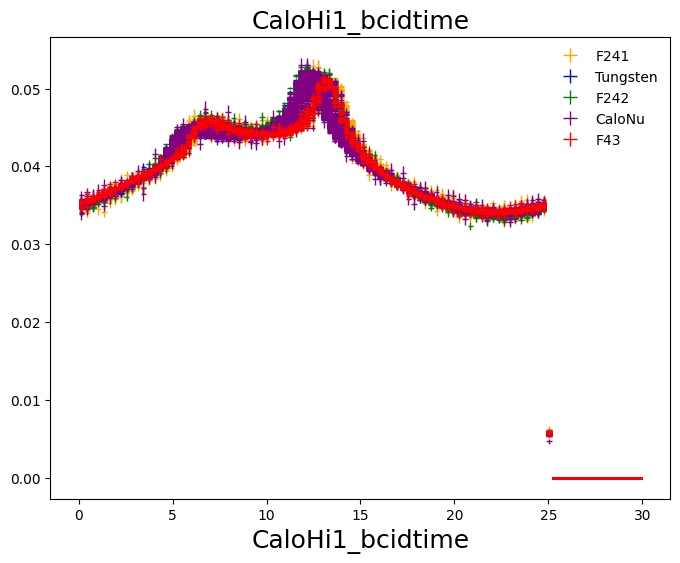

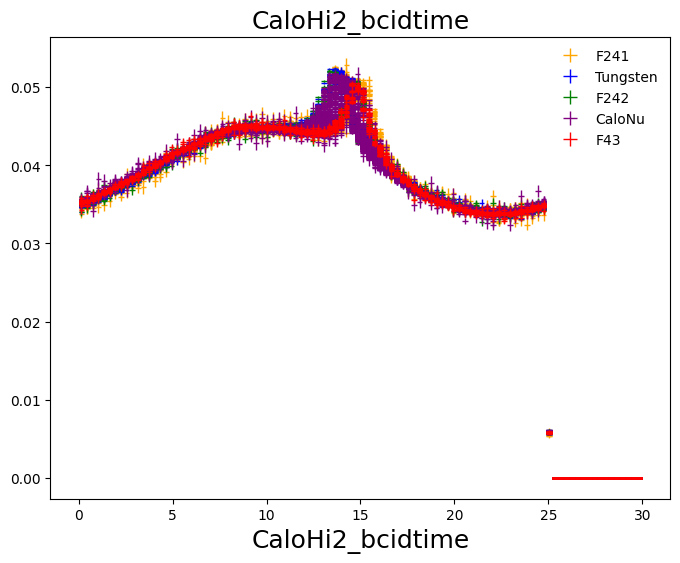

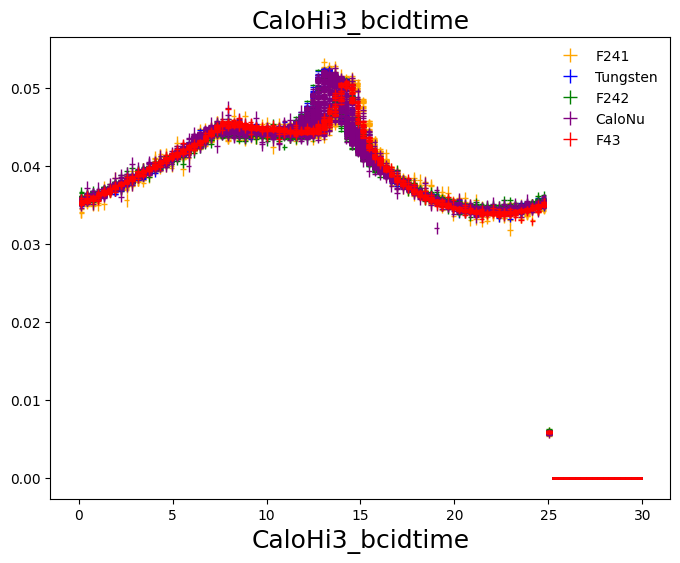

In [9]:
plot_timing_hists(files_2024, bad_runs=bad_runs)